Datasets are from Kaggle

[COVID-19/SARS B-cell Epitope Prediction](https://www.kaggle.com/futurecorporation/epitope-prediction)

In [1]:
# importing libraries: 
import pandas as pd
import numpy as np
from scipy import stats
import itertools

#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


#tests used to check for normality 
from scipy.stats import jarque_bera
from scipy.stats import normaltest

#function used to split dataset
from sklearn.model_selection import train_test_split


#estimators/algorithms
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier


#libraries for evaluating model performance
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score



#setting limit to how dataframe is displayed 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)

#importing training data (has label) 
bcell_data=pd.read_csv('input_bcell.csv')
sars_data=pd.read_csv('input_sars.csv')

#no label (use covid_data after training model with bcell_data and sars_data)
covid_data=pd.read_csv('input_covid.csv')

/Users/nikee/opt/anaconda3/envs/snikee24/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


**First need to determine whether to use the bcell_data or the sars_data for training the models since they both have labeled target.**

In [2]:
#displaying summary info for the training datasets
bcell_data.info()
sars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14387 entries, 0 to 14386
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    14387 non-null  object 
 1   protein_seq          14387 non-null  object 
 2   start_position       14387 non-null  int64  
 3   end_position         14387 non-null  int64  
 4   peptide_seq          14387 non-null  object 
 5   chou_fasman          14387 non-null  float64
 6   emini                14387 non-null  float64
 7   kolaskar_tongaonkar  14387 non-null  float64
 8   parker               14387 non-null  float64
 9   isoelectric_point    14387 non-null  float64
 10  aromaticity          14387 non-null  float64
 11  hydrophobicity       14387 non-null  float64
 12  stability            14387 non-null  float64
 13  target               14387 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.5+ MB
<class 'pandas.core.frame.Dat

* I will be using the bcell_data to train the models since the bcell_data has more records than the sars_data. 

* The sars_data will be treated as an "unlabeled" dataset after finding the best estimator using the bcell_data so that I can test whether the best estimator can predict accurately. (transfer learning)

* Last task: Use the best estimator(s) to predict on the target for the covid_data. 

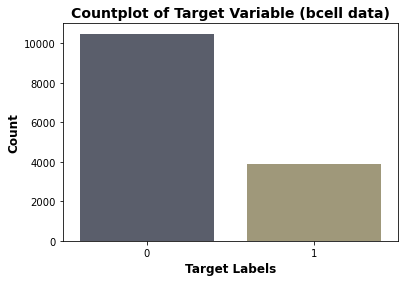

Antibody valence count:
0    10485
1     3902
Name: target, dtype: int64

Percentage of antibody valence:
0    72.878293
1    27.121707
Name: target, dtype: float64


In [3]:
#counting target variable values on the bcell data 
sns.countplot(data=bcell_data, x='target', palette='cividis')
plt.title("Countplot of Target Variable (bcell data)", fontsize=14, weight='heavy')
plt.ylabel("Count", fontsize=12, weight='heavy')
plt.xlabel("Target Labels", fontsize=12, weight='heavy')
plt.show()

# getting value count of target: 
count_bcell=bcell_data['target'].value_counts()
print(f'Antibody valence count:\n{count_bcell}')
print()


#getting percentage on how many + and - for antibody valence there are 
percentage_bcell=bcell_data['target'].value_counts()/len(bcell_data)*100.0
print(f'Percentage of antibody valence:\n{percentage_bcell}')

**There are far more negative antibody valence than positive antibody valence so this dataset is imbalanced.**
* There are 72.8% negative antibody valence  (10,865 / 14907) 
* 27.1% positive antibody valence (4042 / 14907) 

**Since there are more negative antibody valence indicates that most of the antibodies are non binding**

In [4]:
#excluding the object data types and the target variable since I am going to work with only the numerical data types.
bcell_data_features=bcell_data.drop(['parent_protein_id', 'protein_seq', 'peptide_seq','target'], axis=1)

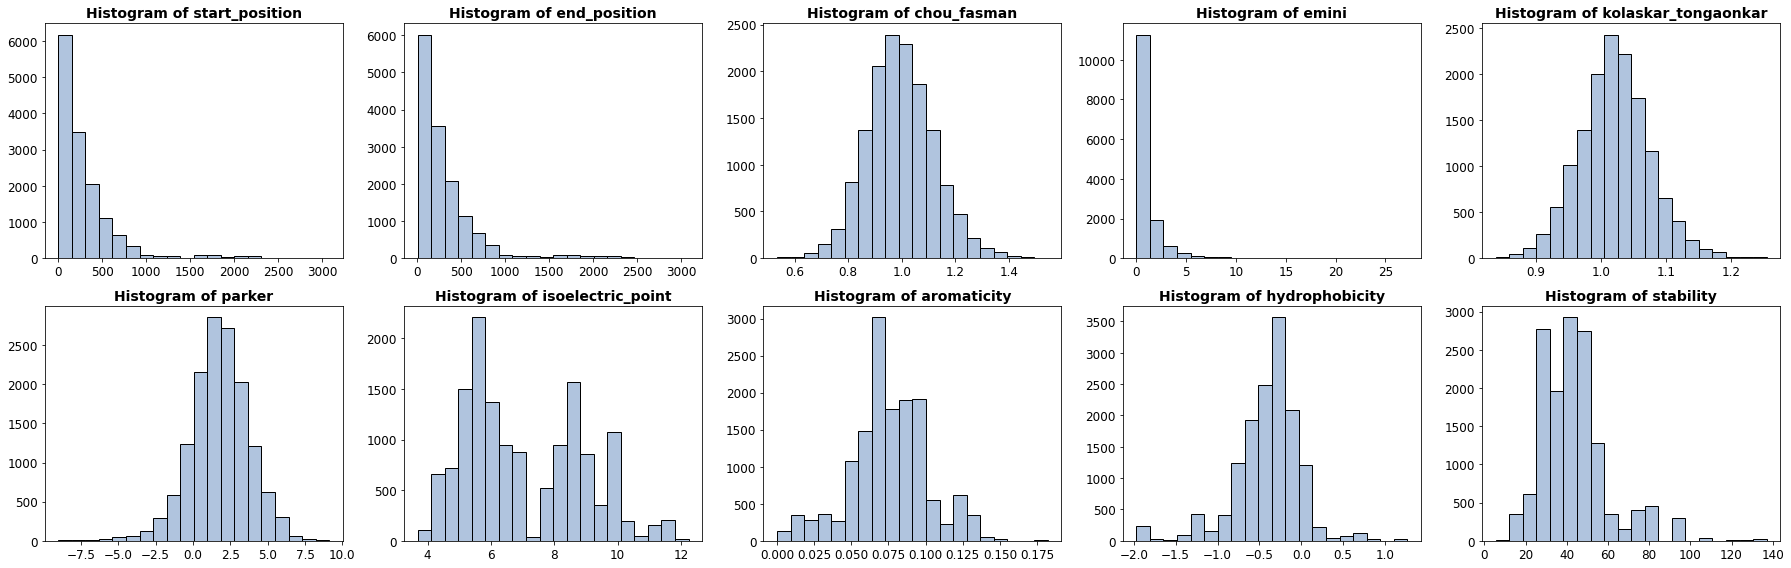

In [5]:
#plotting the variables to check if features are normally distributed
i=1
plt.figure(figsize=(25,8))
for col in bcell_data_features.columns[:]:
    plt.subplot(2,5,i)
    plt.title(f"Histogram of {col}", fontsize=14, weight='heavy')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.hist(bcell_data[col], bins=20, 
             color="lightsteelblue", edgecolor='k')
    i+=1
    
plt.tight_layout()

**Most of the variables do not seem to conform to normality, while a couple are skewed. Will use normality tests later on. For now, checking whether these variables contain outliers using boxplots.**

# Outlier detection

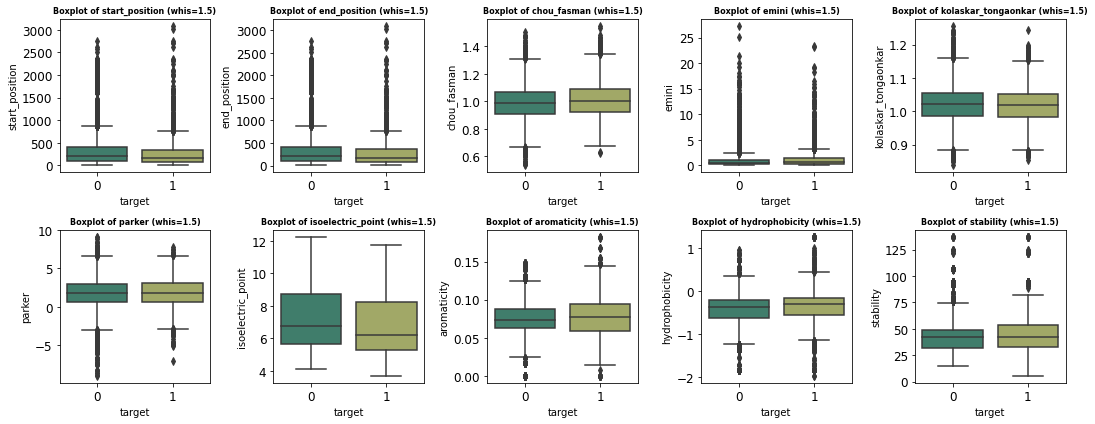

In [6]:
#checking for outliers wrt the target variable 
i=1
plt.figure(figsize=(15,6))
for col in bcell_data_features.columns[:]:
    plt.subplot(2,5,i)
    plt.title(f"Boxplot of {col} (whis=1.5)", fontsize=8, weight='heavy')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=bcell_data_features[col], x=bcell_data['target'], whis=1.5, palette='gist_earth')
    i+=1
plt.tight_layout()

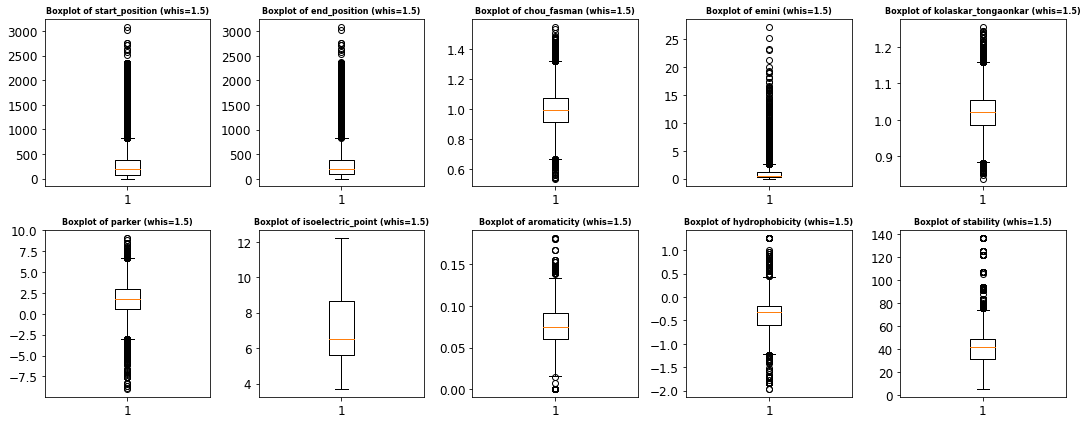

In [7]:
#checking for outliers on the feature variables:

i=1
plt.figure(figsize=(15,6))
for col in bcell_data_features.columns[:]:
    plt.subplot(2,5,i)
    plt.title(f"Boxplot of {col} (whis=1.5)", fontsize=8, weight='heavy')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.boxplot(bcell_data_features[col], whis=1.5)
    i+=1
plt.tight_layout()

**With the exception of the variable, isoelectric_point, the variables contain outliers. To deal with the outliers, applying transformation methods beginning with a two-way winsorization to cap the value of the outliers. Also applying yeo-johnson transformation, which can deal with negative values**

# Dealing with outliers
1. applying winsorize and yeo-johnson transformations. 
2. using goodness of fit statistical testings to determine normality: 
    * jarque-berra test
    * normaltest 

In [8]:
#using outliers to cap the values of the outliers
from scipy.stats.mstats import winsorize

bcell_data['winsorized_start_position']=winsorize(bcell_data['start_position'], (0.05, 0.05))
bcell_data['winsorized_end_position']=winsorize(bcell_data['end_position'], (0.05, 0.05))
bcell_data['winsorized_chou_fasman']=winsorize(bcell_data['chou_fasman'], (0.05, 0.05))

bcell_data['winsorized_emini']=winsorize(bcell_data['emini'], (0.05, 0.05))
bcell_data['winsorized_kolaskar_tongaonkar']=winsorize(bcell_data['kolaskar_tongaonkar'], (0.05, 0.05))
bcell_data['winsorized_parker']=winsorize(bcell_data['parker'], (0.05, 0.05))
bcell_data['winsorized_isoelectric_point']=winsorize(bcell_data['isoelectric_point'],(0.05, 0.05))

bcell_data['winsorized_aromaticity']=winsorize(bcell_data['aromaticity'], (0.05, 0.05))
bcell_data['winsorized_hydrophobicity']=winsorize(bcell_data['hydrophobicity'], (0.05, 0.05))
bcell_data['winsorized_stability']=winsorize(bcell_data['stability'], (0.05, 0.05))



#using another transformation method, yeo-johnson transformation, which can handle negative values. 
bcell_data['yj_start_position'],_=stats.yeojohnson(bcell_data['start_position'])
bcell_data['yj_end_position'],_=stats.yeojohnson(bcell_data['end_position'])
bcell_data['yj_chou_fasman'],_=stats.yeojohnson(bcell_data['chou_fasman'])
bcell_data['yj_emini'],_=stats.yeojohnson(bcell_data['emini'])
bcell_data['yj_kolaskar_tongaonkar'],_=stats.yeojohnson(bcell_data['kolaskar_tongaonkar'])


bcell_data['yj_parker'],_=stats.yeojohnson(bcell_data['parker'])
bcell_data['yj_isoelectric_point'],_=stats.yeojohnson(bcell_data['isoelectric_point'])
bcell_data['yj_aromaticity'],_=stats.yeojohnson(bcell_data['aromaticity'])
bcell_data['yj_hydrophobicity'],_=stats.yeojohnson(bcell_data['hydrophobicity'])
bcell_data['yj_stability'],_=stats.yeojohnson(bcell_data['stability'])

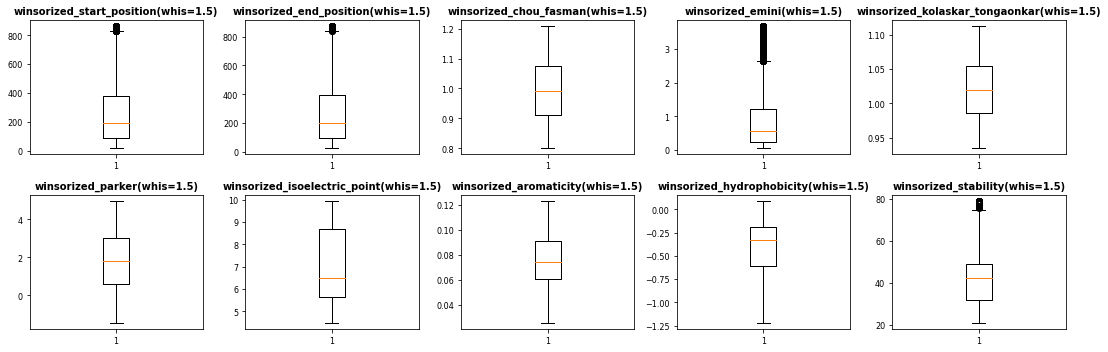

In [9]:
#after applying winsorize transformation on the feature variables, checking if there are still outliers 

i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[14:24]:
    plt.subplot(2,5,i)
    plt.title(f"{col}(whis=1.5)", fontsize=10, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.boxplot(bcell_data[col], whis=1.5)
    i+=1
plt.tight_layout()

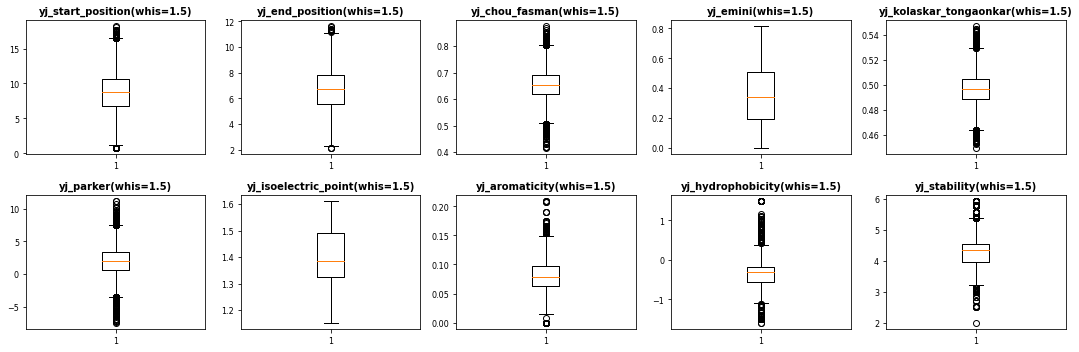

In [10]:
#after applying yj transformation on the feature variables, checking for outliers 

i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[24:34]:
    plt.subplot(2,5,i)
    plt.title(f"{col}(whis=1.5)", fontsize=10, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.boxplot(bcell_data[col], whis=1.5)
    i+=1
plt.tight_layout()

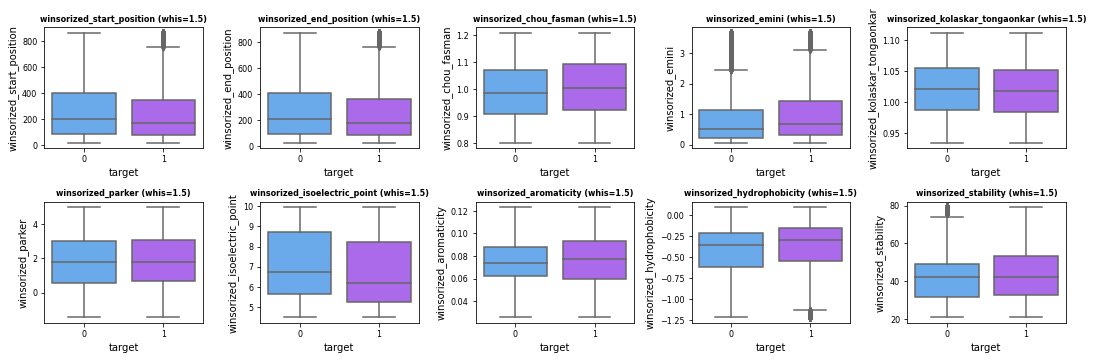

In [11]:
#using the winsorize transformed variables to check for outliers wrt the target variable 
i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[14:24]:
    plt.subplot(2,5,i)
    plt.title(f"{col} (whis=1.5)", fontsize=8, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    sns.boxplot(y=bcell_data[col], x=bcell_data['target'], whis=1.5, palette='cool')
    i+=1
plt.tight_layout()

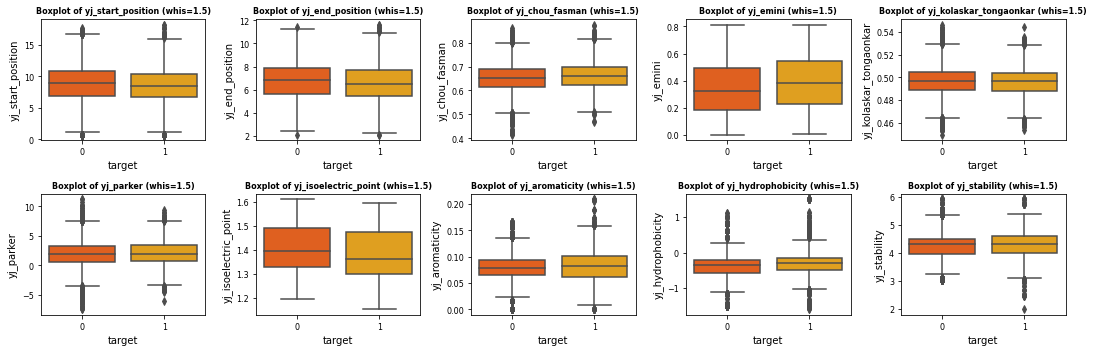

In [12]:
#using the yeo-johnson transformed variables to check for outliers wrt the target variable 
i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[24:34]:
    plt.subplot(2,5,i)
    plt.title(f"Boxplot of {col} (whis=1.5)", fontsize=8, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    sns.boxplot(y=bcell_data[col], x=bcell_data['target'], whis=1.5, palette='autumn')
    i+=1
plt.tight_layout()

**Winsorizing the variables significantly reduced the outliers more than it did for the yeo-johnson transformed variables. Next, using histograms to check for normality.**

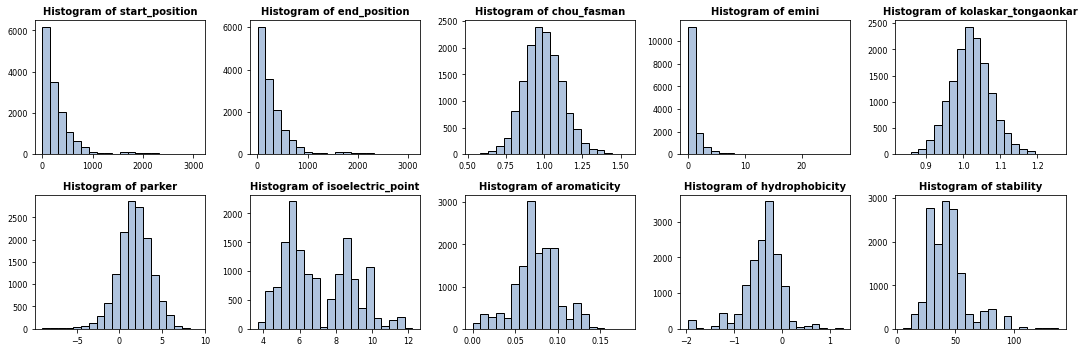

In [13]:
#plotting original variables
i=1
plt.figure(figsize=(15,5))
for col in bcell_data_features.columns[:]:
    plt.subplot(2,5,i)
    plt.title(f"Histogram of {col}", fontsize=10, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.hist(bcell_data[col], bins=20, 
             color="lightsteelblue", edgecolor='k')
    i+=1
    
plt.tight_layout()

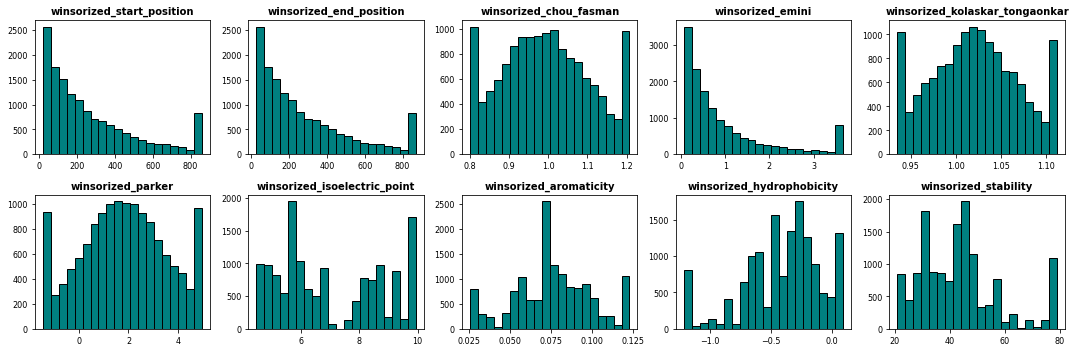

In [14]:
#plotting winsorized variables
i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[14:24]:
    plt.subplot(2,5,i)
    plt.title(f"{col}", fontsize=10, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.hist(bcell_data[col], bins=20, 
             color="teal", edgecolor='k')
    i+=1
    
plt.tight_layout()

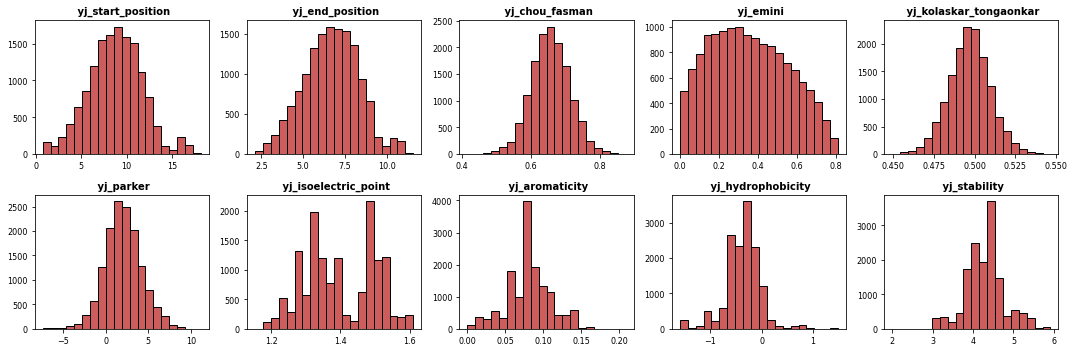

In [15]:
#plotting yj transformed variables
i=1
plt.figure(figsize=(15,5))
for col in bcell_data.columns[24:34]:
    plt.subplot(2,5,i)
    plt.title(f" {col}", fontsize=10, weight='heavy')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.hist(bcell_data[col], bins=20, 
             color="indianred", edgecolor='k')
    i+=1
    
plt.tight_layout()

**Graphically, the winsorized transformed variables do not appear to be normally distributed. On the contrary, the yeo-johnson transformed variables can graphically pass for normality. To verify normality, using goodness of fit tests:**
* Jarque-bera test and Normality test
* can also apply Shapiro-Wilk test 

In [16]:
#checking normality on the winsorize transformed variables: 
print('winsorized_start_position')
jb_stats = jarque_bera(bcell_data["winsorized_start_position"])
norm_stats = normaltest(bcell_data["winsorized_start_position"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


######################################
print()
print('winsorized_end_position')
jb_stats = jarque_bera(bcell_data["winsorized_end_position"])
norm_stats = normaltest(bcell_data["winsorized_end_position"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
######################################
print()
print('winsorized_chou_fasman')
jb_stats = jarque_bera(bcell_data["winsorized_chou_fasman"])
norm_stats = normaltest(bcell_data["winsorized_chou_fasman"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_emini')
jb_stats = jarque_bera(bcell_data["winsorized_emini"])
norm_stats = normaltest(bcell_data["winsorized_emini"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_kolaskar_tongaonkar')
jb_stats = jarque_bera(bcell_data["winsorized_kolaskar_tongaonkar"])
norm_stats = normaltest(bcell_data["winsorized_kolaskar_tongaonkar"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_parker')
jb_stats = jarque_bera(bcell_data["winsorized_parker"])
norm_stats = normaltest(bcell_data["winsorized_parker"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_isoelectric_point')
jb_stats = jarque_bera(bcell_data["winsorized_isoelectric_point"])
norm_stats = normaltest(bcell_data["winsorized_isoelectric_point"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_aromaticity')
jb_stats = jarque_bera(bcell_data["winsorized_aromaticity"])
norm_stats = normaltest(bcell_data["winsorized_aromaticity"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_hydrophobicity')
jb_stats = jarque_bera(bcell_data["winsorized_hydrophobicity"])
norm_stats = normaltest(bcell_data["winsorized_hydrophobicity"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('winsorized_stability')
jb_stats = jarque_bera(bcell_data["winsorized_stability"])
norm_stats = normaltest(bcell_data["winsorized_stability"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


winsorized_start_position
Jarque-Bera test statistics is 3182.1460527338845 and p value is 0.0
Normality test statistics is 2118.7498284743883 and p value is 0.0

winsorized_end_position
Jarque-Bera test statistics is 3161.4680250612632 and p value is 0.0
Normality test statistics is 2108.23733952927 and p value is 0.0

winsorized_chou_fasman
Jarque-Bera test statistics is 416.8466408638532 and p value is 0.0
Normality test statistics is 1161.0420299435107 and p value is 7.637066440905633e-253

winsorized_emini
Jarque-Bera test statistics is 7848.1081345403945 and p value is 0.0
Normality test statistics is 3794.2960721121553 and p value is 0.0

winsorized_kolaskar_tongaonkar
Jarque-Bera test statistics is 342.43143898460823 and p value is 0.0
Normality test statistics is 940.494104784529 and p value is 5.947028431428556e-205

winsorized_parker
Jarque-Bera test statistics is 292.6222119241923 and p value is 0.0
Normality test statistics is 749.5277100067788 and p value is 1.74632775010

In [17]:
#checking for normality on the yeo-johnson transformed variables: 

print('yeo-johnson transformed start_position')
jb_stats = jarque_bera(bcell_data["yj_start_position"])
norm_stats = normaltest(bcell_data["yj_start_position"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


######################################
print()
print('yeo-johnson transformed end_position')
jb_stats = jarque_bera(bcell_data["yj_end_position"])
norm_stats = normaltest(bcell_data["yj_end_position"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
######################################
print()
print('yeo-johnson transformed chou_fasman')
jb_stats = jarque_bera(bcell_data["yj_chou_fasman"])
norm_stats = normaltest(bcell_data["yj_chou_fasman"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed emini')
jb_stats = jarque_bera(bcell_data["yj_emini"])
norm_stats = normaltest(bcell_data["yj_emini"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed kolaskar_tongaonkar')
jb_stats = jarque_bera(bcell_data["yj_kolaskar_tongaonkar"])
norm_stats = normaltest(bcell_data["yj_kolaskar_tongaonkar"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed parker')
jb_stats = jarque_bera(bcell_data["yj_parker"])
norm_stats = normaltest(bcell_data["yj_parker"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed isoelectric_point')
jb_stats = jarque_bera(bcell_data["yj_isoelectric_point"])
norm_stats = normaltest(bcell_data["yj_isoelectric_point"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed aromaticity')
jb_stats = jarque_bera(bcell_data["yj_aromaticity"])
norm_stats = normaltest(bcell_data["yj_aromaticity"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed hydrophobicity')
jb_stats = jarque_bera(bcell_data["yj_hydrophobicity"])
norm_stats = normaltest(bcell_data["yj_hydrophobicity"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

######################################
print()
print('yeo-johnson transformed stability')
jb_stats = jarque_bera(bcell_data["yj_stability"])
norm_stats = normaltest(bcell_data["yj_stability"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


yeo-johnson transformed start_position
Jarque-Bera test statistics is 16.709046918145958 and p value is 0.00023532960334515796
Normality test statistics is 14.54931363428819 and p value is 0.000692877863713869

yeo-johnson transformed end_position
Jarque-Bera test statistics is 13.371053020824078 and p value is 0.0012488570444275648
Normality test statistics is 15.40965922805524 and p value is 0.00045064547501643104

yeo-johnson transformed chou_fasman
Jarque-Bera test statistics is 66.64834335611545 and p value is 3.3306690738754696e-15
Normality test statistics is 49.837342652091145 and p value is 1.506463267911336e-11

yeo-johnson transformed emini
Jarque-Bera test statistics is 605.2330887859574 and p value is 0.0
Normality test statistics is 2234.1564915435188 and p value is 0.0

yeo-johnson transformed kolaskar_tongaonkar
Jarque-Bera test statistics is 48.87113200583274 and p value is 2.442124280577218e-11
Normality test statistics is 38.07798054188056 and p value is 5.3885458722

* Variables that are normally distrubuted as confirmed by the Jarque-Bera test and Normality test is the yeo-johnson transformed start_position 

* After using transformation method, the majority of the variables do not conform to normal distributions, which means that the data points are not relatively similar and still contains outliers

* Proceeding on to checking for target relationship with the featues using a correlation matrix.

# Checking for correlation:

In [18]:
#determining the relationship that target has with the feature variables 
rating_corr=np.abs(bcell_data.iloc[:,1:].corr().loc[:,
                                       "target"]).sort_values(
    ascending=False)


rating_corr

target                            1.000000
winsorized_isoelectric_point      0.133437
isoelectric_point                 0.131513
yj_isoelectric_point              0.125171
yj_hydrophobicity                 0.109581
hydrophobicity                    0.103860
winsorized_hydrophobicity         0.099871
yj_emini                          0.098438
winsorized_emini                  0.089464
chou_fasman                       0.085336
yj_chou_fasman                    0.084613
winsorized_chou_fasman            0.074335
emini                             0.070670
start_position                    0.069898
end_position                      0.069464
winsorized_start_position         0.063106
winsorized_end_position           0.062530
yj_start_position                 0.060471
yj_end_position                   0.058847
aromaticity                       0.040054
yj_aromaticity                    0.039349
winsorized_aromaticity            0.032783
stability                         0.030907
winsorized_

In [19]:
#creating new dataframe for features that has strong relationship with target


bcell_data2=bcell_data[['target',
                         'start_position', 
                         'end_position',
                         'chou_fasman', 
                         'yj_emini',
                            'kolaskar_tongaonkar', 
                         'parker',
                         'winsorized_isoelectric_point',
                             'aromaticity', 
                         'yj_hydrophobicity',
                             'winsorized_stability']]

#### Using Heatmap and correlation method to determine relationship strength of target variable to the features. 
Using The absolute value of the correlation coefficient to gives us the relationship strength. The larger the number, the stronger the relationship.

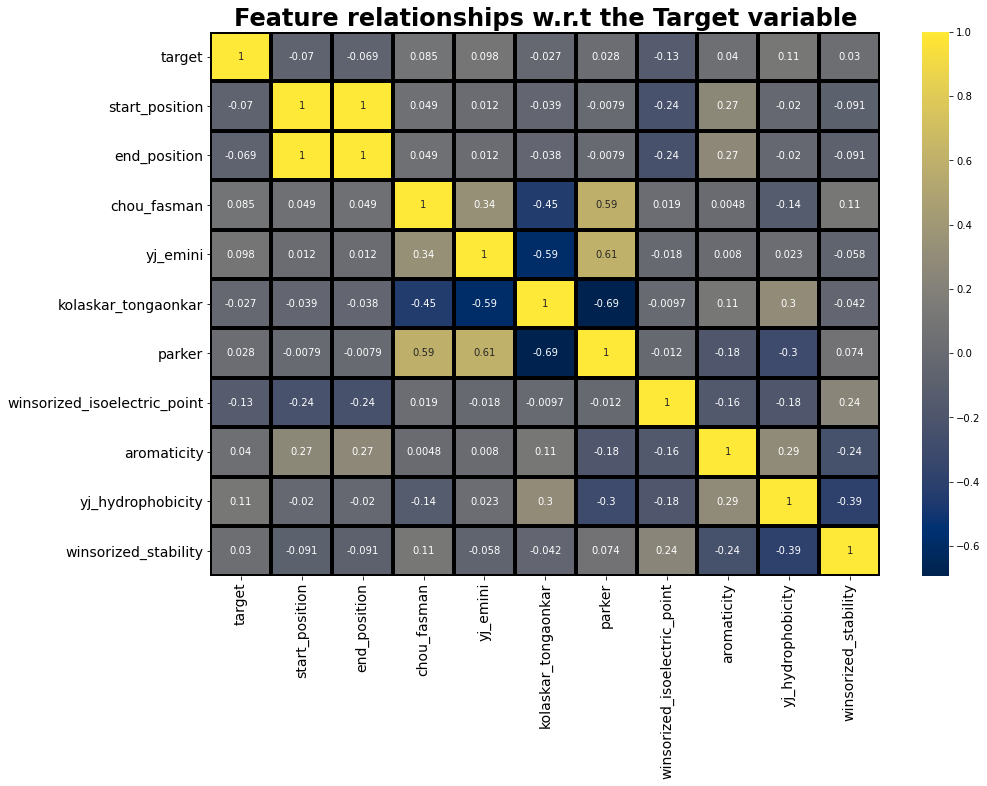

In [20]:
#using heatmap to display Target variable's relationship with features. 
plt.figure(figsize=(15,10))
sns.heatmap(bcell_data2.corr(), annot=True, 
           linecolor="black", linewidths=3, 
           cmap="cividis", cbar=True)
plt.title("Feature relationships w.r.t the Target variable", weight='heavy', 
          fontsize=24)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [21]:
#determining the relationship that target has with the feature variables before algorithm modeling
rating_corr=np.abs(bcell_data2.iloc[:,:].corr().loc[:,
                                       "target"]).sort_values(
    ascending=False)


rating_corr

target                          1.000000
winsorized_isoelectric_point    0.133437
yj_hydrophobicity               0.109581
yj_emini                        0.098438
chou_fasman                     0.085336
start_position                  0.069898
end_position                    0.069464
aromaticity                     0.040054
winsorized_stability            0.030212
parker                          0.028079
kolaskar_tongaonkar             0.026949
Name: target, dtype: float64

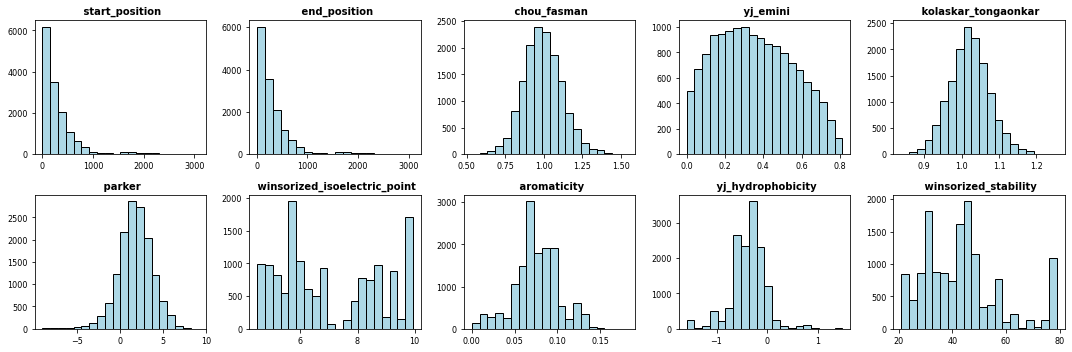

In [22]:
#exploring the variables that will be used for estimator modeling 
i=1
plt.figure(figsize=(15,5))
for features in bcell_data2.describe().columns[1:]:
    plt.subplot(2,5,i)
    plt.title(f" {features}",fontsize=10, weight="heavy")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.hist(bcell_data2[features],bins=20,color='lightblue',edgecolor='k')
    i+=1
plt.tight_layout()

* `start_position`, `end_position`, shows right-skewed distributions.
* `emini` looks unitary distributed
* `chou_fasman`, `parker`, `kolaskar_tongaonkar` can graphically pass for normal distribution. 
* rest of variables are not normal and looks like bi-modal distribution 

# Using different estimators for predictive analysis:
1. ExtraTreesClassifier
2. GradientBoostingClassifier
3. k-nearest neighbors (KNN)
4. LightGBM
5. Logistic Regression
6. Naive Bayes
7. RandomForestClassifier
8. Support Vector Classifier  (SVC)


### Then using 10-fold cross validation procedure to evaluate model performance 

In [23]:
#setting the feature set to variable X
X=bcell_data2.drop(['target'], axis=1)
#isolating the target variables to variable y
y=bcell_data2['target']


#splitting train and test 
X_train, X_test, y_train, y_test=train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=24)

print(X.shape)
print(len(y))

(14387, 10)
14387


In [24]:
#making empty lists to use for visual aid on estimators' mean test cv score 
list_models=[]
list_scores=[]

## ExtraTreesClassifier

In [25]:
#ExtraTreesClassifier


extratrees_clf = ExtraTreesClassifier(n_estimators=100, random_state=24)
#########################################

#this is the model
#fitting our model on the train data in order to make predictions on the test data
extratrees_clf.fit(X_train,y_train)

#once model is trained, we can now get its accuracy score to evaluate how well the models performed
extratrees_clf_score_train=extratrees_clf.score(X_train, y_train)
extratrees_clf_score_test = extratrees_clf.score(X_test, y_test)

#accuracy score measures how well our model is performing
print('ExtraTreesClassifier Accuracy scores:')
print('Training data: {:.3f}'.format(extratrees_clf_score_train))
print('Test data: {:.3f}'.format(extratrees_clf_score_test))
print()

#using cross-validate on ExtraTreesClassifier model 

et_cross_validate_train=cross_validate(extratrees_clf, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

et_cross_validate_test=cross_validate(extratrees_clf, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)

et_cv_train_scores=et_cross_validate_train['test_score']
et_mean_cv_train_score=np.mean(et_cv_train_scores)
et_mean_cv_train_score_percentage=et_mean_cv_train_score*100
et_mean_cv_train_rounded=np.round(et_mean_cv_train_score_percentage, 2)

et_cv_test_scores=et_cross_validate_test['test_score']
et_mean_cv_test_score=np.mean(et_cv_test_scores)
et_mean_cv_test_score_percentage=et_mean_cv_test_score*100
et_mean_cv_test_rounded=np.round(et_mean_cv_test_score_percentage, 2)

list_scores.append(et_mean_cv_test_rounded)
list_models.append('ExtraTreesClassifier')

print('ExtraTreesClassifier mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(et_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(et_mean_cv_test_rounded))

ExtraTreesClassifier Accuracy scores:
Training data: 1.000
Test data: 0.862

ExtraTreesClassifier mean Cross Validate score: 
Mean cv score for the train data is: 85.620
Mean cv score for the test data is: 81.620


## GradientBoostingClassifier

In [26]:
#GradientBoostingClassifier 

# Initialize and fit the model.
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=24)

#fitting the model on the training data
gb_clf.fit(X_train, y_train)


#accuracy for gradient boosting classifier
gb_score_train=gb_clf.score(X_train, y_train)
gb_score_test=gb_clf.score(X_test, y_test)
print('GradientBoostingClassifier Accuracy scores:')
print('Training data: {:.3f}'.format(gb_score_train))
print('Test data: {:.3f}'.format(gb_score_test))
print()


#using cross-validate on gradientboosting classifier model


gb_cross_validate_train=cross_validate(gb_clf, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

gb_cross_validate_test=cross_validate(gb_clf, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)


gb_cv_train_scores=gb_cross_validate_train['test_score']
gb_mean_cv_train_score=np.mean(gb_cv_train_scores)
gb_mean_cv_train_score_percentage=gb_mean_cv_train_score*100
gb_mean_cv_train_rounded=np.round(gb_mean_cv_train_score_percentage, 2)

gb_cv_test_scores=gb_cross_validate_test['test_score']
gb_mean_cv_test_score=np.mean(gb_cv_test_scores)
gb_mean_cv_test_score_percentage=gb_mean_cv_test_score*100
gb_mean_cv_test_rounded=np.round(gb_mean_cv_test_score_percentage, 2)

list_scores.append(gb_mean_cv_test_rounded)
list_models.append('GradientBoostingClassifier')

print('GradientBoostingClassifier mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(gb_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(gb_mean_cv_test_rounded))

GradientBoostingClassifier Accuracy scores:
Training data: 0.822
Test data: 0.804

GradientBoostingClassifier mean Cross Validate score: 
Mean cv score for the train data is: 80.430
Mean cv score for the test data is: 78.670


## KNN

In [27]:
#KNN


knn = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

# Then  fit the model
knn.fit(X_train, y_train)


knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)


print('KNN Accuracy Scores: ')
print('Train score: {:.3f}'.format(knn_train_score))
print('Test score: {:.3f}'.format(knn_test_score))
print()

#using cross-validate
knn_cross_validate_train=cross_validate(knn, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

knn_cross_validate_test=cross_validate(knn, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)


knn_cross_validate_train_scores=knn_cross_validate_train['test_score']
knn_mean_cv_train_score=np.mean(knn_cross_validate_train_scores)
knn_mean_mean_cv_train_percentage=knn_mean_cv_train_score*100
knn_mean_cv_train_rounded=np.round(knn_mean_mean_cv_train_percentage,2)



knn_cv_test_scores=knn_cross_validate_test['test_score']
knn_mean_cv_test_score=np.mean(knn_cv_test_scores)
knn_mean_mean_cv_test_percentage=knn_mean_cv_test_score*100
knn_mean_cv_test_rounded=np.round(knn_mean_mean_cv_test_percentage,2)


list_scores.append(knn_mean_cv_test_rounded)
list_models.append('KNN')

print('KNN mean Cross Validate scores: ')
print('Mean cv score for the train data is: {:.3f}'.format(knn_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(knn_mean_cv_test_rounded))

KNN Accuracy Scores: 
Train score: 1.000
Test score: 0.740

KNN mean Cross Validate scores: 
Mean cv score for the train data is: 73.980
Mean cv score for the test data is: 70.710


# LightGBM 

In [28]:
# LightGBM

lgbm=LGBMClassifier(n_estimators=100, random_state=24)


lgbm.fit(X_train, y_train)


#accuracy
lgbm_score_train=lgbm.score(X_train, y_train)
lgbm_score_test=lgbm.score(X_test, y_test)
print('LightGBM Accuracy Scores:')
print('Training data: {:.3f}'.format(lgbm_score_train))
print('Test data: {:.3f}'.format(lgbm_score_test))
print()

#checking accuracy score using cross-validate on LogisticRegression model


lgbm_cross_validate_train=cross_validate(lgbm, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

lgbm_cross_validate_test=cross_validate(lgbm, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)


lgbm_cross_validate_train_scores=lgbm_cross_validate_train['test_score']
lgbm_mean_cv_train_score=np.mean(lgbm_cross_validate_train_scores)
lgbm_mean_mean_cv_train_percentage=lgbm_mean_cv_train_score*100
lgbm_mean_cv_train_rounded=np.round(lgbm_mean_mean_cv_train_percentage,2)


lgbm_cv_test_scores=lgbm_cross_validate_test['test_score']
lgbm_mean_cv_test_score=np.mean(lgbm_cv_test_scores)
lgbm_mean_mean_cv_test_percentage=lgbm_mean_cv_test_score*100
lgbm_mean_cv_test_rounded=np.round(lgbm_mean_mean_cv_test_percentage,2)




list_scores.append(lgbm_mean_cv_test_rounded)
list_models.append('LightGBM')



print('LightGBM mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(lgbm_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(lgbm_mean_cv_test_rounded))

LightGBM Accuracy Scores:
Training data: 0.898
Test data: 0.844

LightGBM mean Cross Validate score: 
Mean cv score for the train data is: 84.160
Mean cv score for the test data is: 80.440


## Logistic Regression 

In [29]:
# Logistic Regression 

lr=LogisticRegression(max_iter=1000, random_state=24)


lr.fit(X_train, y_train)


#accuracy
lr_score_train=lr.score(X_train, y_train)
lr_score_test=lr.score(X_test, y_test)
print('LogisticRegression Accuracy Scores:')
print('Training data: {:.3f}'.format(lr_score_train))
print('Test data: {:.3f}'.format(lr_score_test))
print()

#checking accuracy score using cross-validate on LogisticRegression model


lr_cross_validate_train=cross_validate(lr, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

lr_cross_validate_test=cross_validate(lr, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)


lr_cross_validate_train_scores=lr_cross_validate_train['test_score']
lr_mean_cv_train_score=np.mean(lr_cross_validate_train_scores)
lr_mean_mean_cv_train_percentage=lr_mean_cv_train_score*100
lr_mean_cv_train_rounded=np.round(lr_mean_mean_cv_train_percentage,2)


lr_cv_test_scores=lr_cross_validate_test['test_score']
lr_mean_cv_test_score=np.mean(lr_cv_test_scores)
lr_mean_mean_cv_test_percentage=lr_mean_cv_test_score*100
lr_mean_cv_test_rounded=np.round(lr_mean_mean_cv_test_percentage,2)




list_scores.append(lr_mean_cv_test_rounded)
list_models.append('Logistic Regression')



print('LogisticRegression mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(lr_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(lr_mean_cv_test_rounded))

LogisticRegression Accuracy Scores:
Training data: 0.735
Test data: 0.731

LogisticRegression mean Cross Validate score: 
Mean cv score for the train data is: 73.390
Mean cv score for the test data is: 72.520


## Naive Bayes

In [30]:
nb=GaussianNB()


# fitting the model
nb.fit(X_train, y_train)


nb_train_pred=nb.predict(X_train)
nb_train_score=accuracy_score(y_train, nb_train_pred)

nb_test_pred=nb.predict(X_test)
nb_test_score=accuracy_score(y_test, nb_test_pred)


print('Naive Bayes accuracy scores: ')
print('Train score: {:.3f}'.format(nb_train_score))
print('Test score: {:.3f}'.format(nb_test_score))
print()

#using 10-fold cross-validation procedure 
nb_cross_validate_train=cross_validate(nb, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

nb_cross_validate_test=cross_validate(nb, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)

nb_cv_train_scores=nb_cross_validate_train['test_score']
nb_mean_cv_train_score=np.mean(nb_cv_train_scores)
nb_mean_cv_train_score_percentage=nb_mean_cv_train_score*100
nb_mean_cv_train_rounded=np.round(nb_mean_cv_train_score_percentage, 2)

nb_cv_test_scores=nb_cross_validate_test['test_score']
nb_mean_cv_test_score=np.mean(nb_cv_test_scores)
nb_mean_cv_test_score_percentage=nb_mean_cv_test_score*100
nb_mean_cv_test_rounded=np.round(nb_mean_cv_test_score_percentage,2)

list_scores.append(nb_mean_cv_test_rounded)
list_models.append('Naive Bayes')

print('Naive Bayes mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(nb_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(nb_mean_cv_test_rounded))

Naive Bayes accuracy scores: 
Train score: 0.714
Test score: 0.716

Naive Bayes mean Cross Validate score: 
Mean cv score for the train data is: 71.280
Mean cv score for the test data is: 69.740


## RandomForestClassifier

In [31]:
#creating model using estimator: RandomForestClassifier

rf_clf = ensemble.RandomForestClassifier(n_estimators = 100, 
                                         random_state = 24)

#fitting our model on the train data, in order to make predictions on the test data.
rf_clf.fit(X_train,y_train)

#after training data, we now get its accuracy score to see how well it performed 
rf_clf_score_train= rf_clf.score(X_train, y_train)
#using test data to evaluate the model's performance 
rf_clf_score_test= rf_clf.score(X_test, y_test)


#accuracy score measures how well our model is performing
print('RandomForestClassifier Accuracy scores:')
print('Train data: {:.3f}'.format(rf_clf_score_train))
print('Test data: {:.3f}'.format(rf_clf_score_test))
print()


#using cross-validate on RandomForestClassifier model 
from sklearn.model_selection import cross_validate

rf_cross_validate_train=cross_validate(rf_clf, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

rf_cross_validate_test=cross_validate(rf_clf, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)

#sorted(rf_yj_cross_validate.keys())
rf_cv_train_scores=rf_cross_validate_train['test_score']
rf_mean_cv_train_score=np.mean(rf_cv_train_scores)
rf_mean_cv_train_score_percentage=rf_mean_cv_train_score*100
rf_mean_cv_train_rounded=np.round(rf_mean_cv_train_score_percentage, 2)

rf_cv_test_scores=rf_cross_validate_test['test_score']
rf_mean_cv_test_score=np.mean(rf_cv_test_scores)
rf_mean_cv_test_score_percentage=rf_mean_cv_test_score*100
rf_mean_cv_test_rounded=np.round(rf_mean_cv_test_score_percentage, 2)

list_scores.append(rf_mean_cv_test_rounded)
list_models.append('RandomForestClassifier')

print('RandomForestClassifier mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(rf_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(rf_mean_cv_test_rounded))

RandomForestClassifier Accuracy scores:
Train data: 1.000
Test data: 0.865

RandomForestClassifier mean Cross Validate score: 
Mean cv score for the train data is: 86.200
Mean cv score for the test data is: 81.550


## Support Vector Classifier

In [32]:
#Support Vector Classifier
svc=SVC(max_iter=-1, random_state=24)
svc.fit(X_train, y_train)


#accuracy
svc_score_train=svc.score(X_train, y_train)
svc_score_test=svc.score(X_test, y_test)
print('Support Vector Classifier Accuracy Scores: ')
print('Training data: {:.3f}'.format(svc_score_train))
print('Test data: {:.3f}'.format(svc_score_test))
print()

#using cross-validate on Support Vector Classifier

svc_cross_validate_train=cross_validate(svc, X_train, y_train,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

svc_cross_validate_test=cross_validate(svc, X_test, y_test,
                                        scoring="accuracy", cv=10,
                                        verbose=0)

svc_cv_train_scores=svc_cross_validate_train['test_score']
svc_mean_cv_train_score=np.mean(svc_cv_train_scores)
svc_mean_cv_train_score_percentage=svc_mean_cv_train_score*100
svc_mean_cv_train_rounded=np.round(svc_mean_cv_train_score_percentage, 2)

svc_cv_test_scores=svc_cross_validate_test['test_score']
svc_mean_cv_test_score=np.mean(svc_cv_test_scores)
svc_mean_cv_test_score_percentage=svc_mean_cv_test_score*100
svc_mean_cv_test_rounded=np.round(svc_mean_cv_test_score_percentage, 2)

list_scores.append(svc_mean_cv_test_rounded)
list_models.append("SVC")

print('SVC mean Cross Validate score: ')
print('Mean cv score for the train data is: {:.3f}'.format(svc_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(svc_mean_cv_test_rounded))

Support Vector Classifier Accuracy Scores: 
Training data: 0.731
Test data: 0.721

SVC mean Cross Validate score: 
Mean cv score for the train data is: 73.070
Mean cv score for the test data is: 72.130


In [33]:
#creating empty list to store the mean train cv scores
cv_train=[]

#constructing the mean train cv scores for each of the estimators used
cv_train.append(et_mean_cv_train_rounded)
cv_train.append(gb_mean_cv_train_rounded)
cv_train.append(knn_mean_cv_train_rounded)
cv_train.append(lgbm_mean_cv_train_rounded)
cv_train.append(lr_mean_cv_train_rounded)
cv_train.append(nb_mean_cv_train_rounded)
cv_train.append(rf_mean_cv_train_rounded)
cv_train.append(svc_mean_cv_train_rounded)

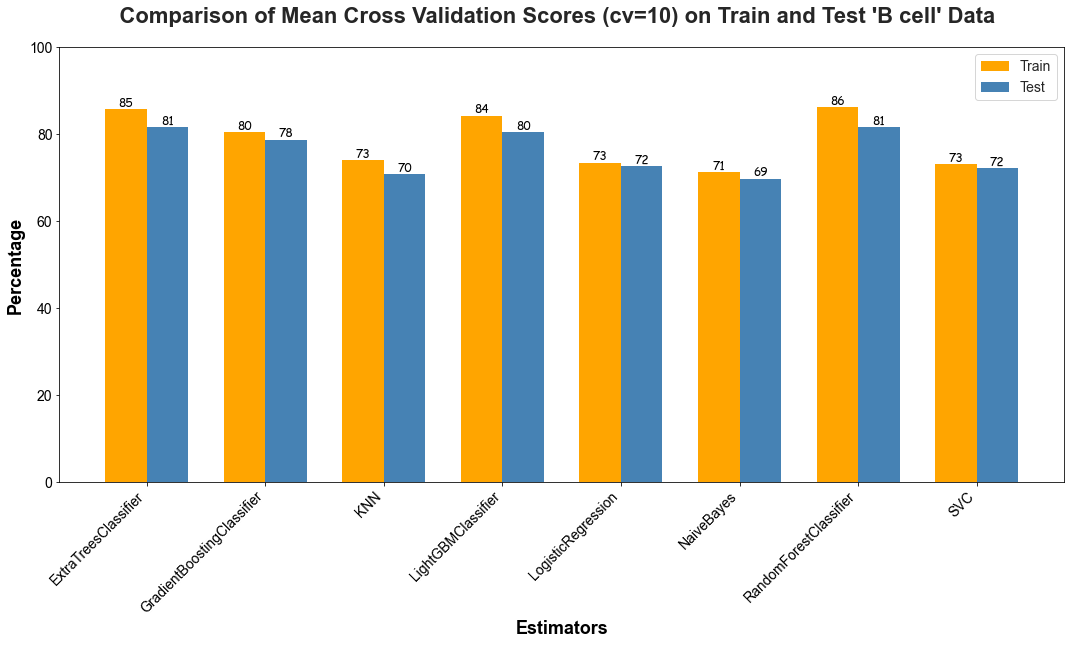

In [34]:
#making bar graph to display mean train cv scores and mean test cv scores

#specifying the count of ticks 
N = 8


ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()



cv_train=cv_train
bar1 = ax.bar(ind, cv_train, width, color="orange")

cv_test = list_scores
bar2 = ax.bar(ind + width, cv_test, width, color='steelblue')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("ExtraTreesClassifier", "GradientBoostingClassifier", 'KNN', 'LightGBMClassifier',
          'LogisticRegression', 'NaiveBayes', 'RandomForestClassifier', 'SVC'))




#making a function that displays height of each bar, which represents the mean cv score 
def label(values):
    for val in values:
        height = val.get_height()
        ax.text(val.get_x() + val.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom',
                fontsize=12, fontweight='normal', color='black', fontname='Comic Sans MS')
label(bar1)
label(bar2)

sns.set_style("white")


# Labeling axis and specifying ticks and y max limit
plt.suptitle("    Comparison of Mean Cross Validation Scores (cv=10) on Train and Test 'B cell' Data", 
          fontsize=22, weight='bold', y=0.95)

plt.xlabel("Estimators", fontsize=18,weight='bold')
plt.ylabel("Percentage", fontsize=18,weight='bold')

plt.legend(['Train', 'Test'],loc='upper right',prop={"size":14})

plt.xticks(rotation=45, horizontalalignment='right', 
           weight='normal', fontsize=14)
plt.yticks(weight='normal', fontsize=14)

plt.ylim(top=100) #setting y-axis limit value 


#setting size for figure
plt.gcf().set_size_inches(18, 8)

plt.show()

* Models are not overfitting or underfitting.
* Tree-based models performed better than other models.
* Best estimators are ET, RF

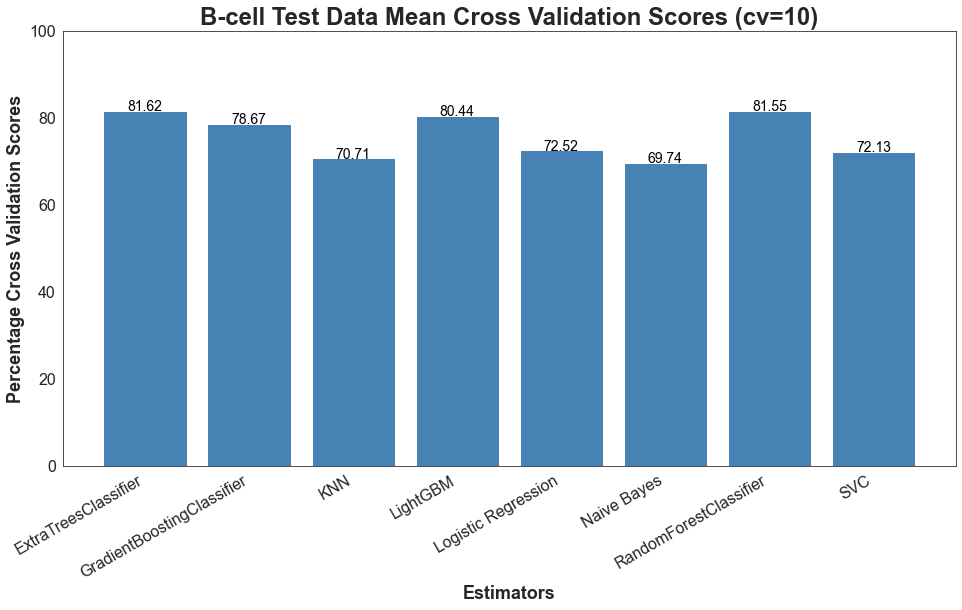

In [35]:
#using bar graph to displaying only the mean test cv scores of estimators 

plt.figure(figsize=(16,8))
sns.set_style("white")

x_models=list_models
y_scores=list_scores

plt.bar(x_models,y_scores, color='steelblue')

#labeling each bar with their cv score value. 
for i in range(len(y_scores)):
    plt.annotate(str(y_scores[i]), xy=(x_models[i],y_scores[i]), ha='center', 
                 fontsize=14,fontweight='normal', color='black') #va='bottom')
    

    

plt.title("B-cell Test Data Mean Cross Validation Scores (cv=10)", fontsize=24,weight='heavy')
plt.xlabel('Estimators', fontsize=18, weight='heavy')
plt.ylabel('Percentage Cross Validation Scores', fontsize=18, weight='heavy')

plt.xticks(rotation=30, horizontalalignment='right', 
           weight='normal', fontsize=16)
plt.yticks(weight='normal', fontsize=16)

plt.ylim(top=100) #setting y-axis limit value 


plt.show()

**As shown the tree-based models (ExtraTrees, GradientBoosting, RandomForest, and LightGBM) has a higher mean CV score than the others. Next using StandardScaling to determine whether model performance of each estimator improves when dealing with scaled features.**

# Feature Scaling 

* Now using scaling, which is an optimization method that scales the features so that they are approximately the same scale. The main goal of standardizing features is to help convergence of the technique used for optimization.

* Algorithms that are NOT Distance based is NOT affected by Feature Scaling like Tree-based models, which are usually robust to numerical instabilities that may impair convergence and precision. Though this is the case, I will still use scaling on tree based models to verify if these statements are true.

* Need to apply scaled features to k-nearest neighbors because it uses  Euclidean distance measure, which is sensitive to magnitudes, so using scaled features so that the features weigh in equally. 

* Applying scaled features to SVC because it is not very robust to outliers so it would be helpful to normalize the training data by using the scaled features. 


In [36]:
bcell_data2.describe()

,target,start_position,end_position,chou_fasman,yj_emini,kolaskar_tongaonkar,parker,winsorized_isoelectric_point,aromaticity,yj_hydrophobicity,winsorized_stability
count,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000
mean,0.271217,297.675818,308.085077,0.994706,0.356196,1.021188,1.767137,7.024583,0.075727,-0.366105,43.346868
std,0.444603,353.741450,353.733297,0.124772,0.198890,0.053804,1.968985,1.777685,0.025767,0.350350,14.685881
min,0.000000,1.000000,6.000000,0.534000,-0.000000,0.838000,-9.029000,4.487366,0.000000,-1.593457,20.961830
25%,0.000000,84.000000,95.000000,0.911000,0.194328,0.986000,0.600000,5.621033,0.060606,-0.556333,31.614529
50%,0.000000,191.000000,200.000000,0.990000,0.342388,1.020000,1.793000,6.499573,0.074534,-0.314266,42.287268
75%,1.000000,382.000000,393.000000,1.074000,0.509640,1.055000,3.009500,8.676575,0.091312,-0.183944,49.101172
max,1.000000,3079.000000,3086.000000,1.546000,0.811755,1.255000,9.120000,9.940857,0.182254,1.488568,79.027143


In [37]:
# Scaling features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc=scaler.fit_transform(X)
X_scaled = pd.DataFrame(sc, columns=X.columns.values)



y=bcell_data2['target']

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled=train_test_split(X_scaled, 
                                                  y,
                                                  test_size=0.2,
                                                 random_state=24)

**After scaling, the features are now roughly the same scale. Now using scaled dataset to train on all the estimators to determine whether their cross validation scores would improve.**

In [38]:
#making empty lists to use for visual aid on estimators' mean cv score 

scaledlist_scores=[]
scaledlist_models=[]

In [39]:
#ExtraTreesClassifier


et_scaled = ExtraTreesClassifier(n_estimators=100, random_state=24)
#########################################

#fitting our model on the train data in order to make predictions on the test data
et_scaled.fit(X_train_scaled,y_train_scaled)

et_scaled_cross_validate_train=cross_validate(et_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

et_scaled_cross_validate_test=cross_validate(et_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)



et_scaled_cv_train_scores=et_scaled_cross_validate_train['test_score']
et_scaled_mean_cv_train_score=np.mean(et_scaled_cv_train_scores)
et_train_percent=et_scaled_mean_cv_train_score*100
et_scaled_rounded_train=np.round(et_train_percent,2)



et_scaled_cv_test_scores=et_scaled_cross_validate_test['test_score']
et_scaled_mean_cv_test_score=np.mean(et_scaled_cv_test_scores)
et_test_percent=et_scaled_mean_cv_test_score*100
et_scaled_rounded_test=np.round(et_test_percent,2)


#adding to list for use in making visual aid
scaledlist_scores.append(et_scaled_rounded_test)
scaledlist_models.append('ExtraTreesClassifier')


print('ExtraTreesClassifier mean Cross Validate score on scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(et_scaled_rounded_train))
print('Mean cv score for the test data is: {:.3f}'.format(et_scaled_rounded_test))

ExtraTreesClassifier mean Cross Validate score on scaled features: 
Mean cv score for the train data is: 85.640
Mean cv score for the test data is: 81.580


In [40]:
#GradientBoostingClassifier 

# Initialize and fit the model.
gb_scaled = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=24)

#fitting the model on the training data
gb_scaled.fit(X_train_scaled, y_train_scaled)

#fitting our model on the train data in order to make predictions on the test data
gb_scaled.fit(X_train_scaled,y_train_scaled)

gb_scaled_cross_validate_train=cross_validate(gb_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

gb_scaled_cross_validate_test=cross_validate(gb_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)



gb_scaled_cv_train_scores=gb_scaled_cross_validate_train['test_score']
gb_scaled_mean_cv_train_score=np.mean(gb_scaled_cv_train_scores)
gb_train_percent=gb_scaled_mean_cv_train_score*100
gb_scaled_rounded_train=np.round(gb_train_percent,2)



gb_scaled_cv_test_scores=gb_scaled_cross_validate_test['test_score']
gb_scaled_mean_cv_test_score=np.mean(gb_scaled_cv_test_scores)
gb_test_percent=gb_scaled_mean_cv_test_score*100
gb_scaled_rounded_test=np.round(gb_test_percent,2)


scaledlist_scores.append(gb_scaled_rounded_test)
scaledlist_models.append('GradientBoostingClassifier')


print('GradientBoostingClassifier  mean Cross Validate score on scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(gb_scaled_rounded_train))
print('Mean cv score for the test data is: {:.3f}'.format(gb_scaled_rounded_test))

GradientBoostingClassifier  mean Cross Validate score on scaled features: 
Mean cv score for the train data is: 80.430
Mean cv score for the test data is: 78.670


In [41]:
# feature scaling on KNN
# expecting enhanced model performance 

knn_scaled = neighbors.KNeighborsClassifier(n_neighbors=10)

# Then  fit the model
knn_scaled.fit(X_train_scaled, y_train_scaled)


# cross validating scores for knn using scaled features
knn_scaled_cross_validate_train=cross_validate(knn_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

knn_scaled_cross_validate_test=cross_validate(knn_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

knn_scaled_cross_validate_train_scores=knn_scaled_cross_validate_train['test_score']
knn_scaled_mean_cv_train_score=np.mean(knn_scaled_cross_validate_train_scores)
knn_scaled_mean_cv_train_score_percentage=knn_scaled_mean_cv_train_score*100
knn_scaled_mean_train_cv_rounded=np.round(knn_scaled_mean_cv_train_score_percentage,2)


knn_scaled_cv_test_scores=knn_scaled_cross_validate_test['test_score']
knn_scaled_mean_cv_test_score=np.mean(knn_scaled_cv_test_scores)
knn_scaled_mean_cv_test_score_percentage=knn_scaled_mean_cv_test_score*100
knn_scaled_mean_cv_rounded=np.round(knn_scaled_mean_cv_test_score_percentage,2)

scaledlist_scores.append(knn_scaled_mean_cv_rounded)
scaledlist_models.append('KNN')


print('KNN mean Cross Validate score for scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(knn_scaled_mean_train_cv_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(knn_scaled_mean_cv_rounded))

KNN mean Cross Validate score for scaled features: 
Mean cv score for the train data is: 77.870
Mean cv score for the test data is: 75.020


In [42]:
# LGBM

lgbm=LGBMClassifier(n_estimators=100, random_state=24)

lgbm.fit(X_train_scaled, y_train_scaled)



# cross validating scores for knn using scaled features

lgbm_cross_validate_train=cross_validate(lgbm, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

lgbm_cross_validate_test=cross_validate(lgbm, X_test_scaled, y_test_scaled,
                                        scoring="accuracy", cv=10,
                                        verbose=0)


lgbm_cross_validate_train_scores=lgbm_cross_validate_train['test_score']
lgbm_mean_cv_train_score=np.mean(lgbm_cross_validate_train_scores)
lgbm_mean_mean_cv_train_percentage=lgbm_mean_cv_train_score*100
lgbm_mean_cv_train_rounded=np.round(lgbm_mean_mean_cv_train_percentage,2)


lgbm_cv_test_scores=lgbm_cross_validate_test['test_score']
lgbm_mean_cv_test_score=np.mean(lgbm_cv_test_scores)
lgbm_mean_mean_cv_test_percentage=lgbm_mean_cv_test_score*100
lgbm_mean_cv_test_rounded=np.round(lgbm_mean_mean_cv_test_percentage,2)




scaledlist_scores.append(lgbm_mean_cv_test_rounded)
scaledlist_models.append('LightGBM')



print('LightGBM mean Cross Validate score for scaled_features: ')
print('Mean cv score for the train data is: {:.3f}'.format(lgbm_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(lgbm_mean_cv_test_rounded))

LightGBM mean Cross Validate score for scaled_features: 
Mean cv score for the train data is: 84.030
Mean cv score for the test data is: 81.170


In [43]:
# Logistic Regression 

lr_scaled=LogisticRegression(max_iter=1000, random_state=24)


lr_scaled.fit(X_train_scaled, y_train_scaled)



#checking accuracy score using cross-validate on LogisticRegression model


lr_scaled_cross_validate_train=cross_validate(lr_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10,
                                   verbose=0)

lr_scaled_cross_validate_test=cross_validate(lr_scaled, X_test_scaled, y_test_scaled,
                                        scoring="accuracy", cv=10,
                                        verbose=0)

lr_scaled_cross_validate_train_scores=lr_scaled_cross_validate_train['test_score']
lr_scaled_mean_cv_train_score=np.mean(lr_scaled_cross_validate_train_scores)
lr_scaled_mean_cv_train_score_percentage=lr_scaled_mean_cv_train_score*100
lr_scaled_mean_cv_train_rounded=np.round(lr_scaled_mean_cv_train_score_percentage,2)



lr_scaled_cv_test_scores=lr_scaled_cross_validate_test['test_score']
lr_scaled_mean_cv_test_score=np.mean(lr_scaled_cv_test_scores)
lr_scaled_mean_cv_test_score_percentage=lr_scaled_mean_cv_test_score*100
lr_scaled_mean_cv_test_rounded=np.round(lr_scaled_mean_cv_test_score_percentage,2)

scaledlist_scores.append(lr_scaled_mean_cv_test_rounded)
scaledlist_models.append('LogisticRegression')


print('LogisticRegression mean Cross Validate score for scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(lr_scaled_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(lr_scaled_mean_cv_test_rounded))

LogisticRegression mean Cross Validate score for scaled features: 
Mean cv score for the train data is: 73.710
Mean cv score for the test data is: 72.900


In [44]:
# feature scaling on GaussianNB()

nb_scaled = GaussianNB()

# Then  fit the model
nb_scaled.fit(X_train_scaled, y_train_scaled)


# cross validating scores for  using scaled features
nb_scaled_cross_validate_train=cross_validate(nb_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

nb_scaled_cross_validate_test=cross_validate(nb_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

nb_scaled_cross_validate_train_scores=nb_scaled_cross_validate_train['test_score']
nb_scaled_mean_cv_train_score=np.mean(nb_scaled_cross_validate_train_scores)
nb_scaled_mean_cv_train_score_percentage=nb_scaled_mean_cv_train_score*100
nb_scaled_mean_cv_rounded_train=np.round(nb_scaled_mean_cv_train_score_percentage,2)


nb_scaled_cv_test_scores=nb_scaled_cross_validate_test['test_score']
nb_scaled_mean_cv_test_score=np.mean(nb_scaled_cv_test_scores)
nb_scaled_mean_cv_test_score_percentage=nb_scaled_mean_cv_test_score*100
nb_scaled_mean_cv_rounded_test=np.round(nb_scaled_mean_cv_test_score_percentage,2)


scaledlist_scores.append(nb_scaled_mean_cv_rounded_test)
scaledlist_models.append('Naive Bayes')


print('NB mean Cross Validate score for scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(nb_scaled_mean_cv_rounded_train))
print('Mean cv score for the test data is: {:.3f}'.format(nb_scaled_mean_cv_rounded_test))

NB mean Cross Validate score for scaled features: 
Mean cv score for the train data is: 71.290
Mean cv score for the test data is: 69.390


In [45]:
# feature scaling RandomForestClassifier

rf_scaled = ensemble.RandomForestClassifier(n_estimators = 100, random_state = 24)

# Then  fit the model
rf_scaled.fit(X_train_scaled, y_train_scaled)


rf_scaled_cross_validate_train=cross_validate(rf_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

rf_scaled_cross_validate_test=cross_validate(rf_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)



rf_scaled_cv_train_scores=rf_scaled_cross_validate_train['test_score']
rf_scaled_mean_cv_train_score=np.mean(rf_scaled_cv_train_scores)
rf_train_percent=rf_scaled_mean_cv_train_score*100
rf_scaled_rounded_train=np.round(rf_train_percent,2)



rf_scaled_cv_test_scores=rf_scaled_cross_validate_test['test_score']
rf_scaled_mean_cv_test_score=np.mean(rf_scaled_cv_test_scores)
rf_test_percent=rf_scaled_mean_cv_test_score*100
rf_scaled_rounded_test=np.round(rf_test_percent,2)


scaledlist_scores.append(rf_scaled_rounded_test)
scaledlist_models.append('RandomForestClassifier')


print('RandomForestClassifier mean Cross Validate score on scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(rf_scaled_rounded_train))
print('Mean cv score for the test data is: {:.3f}'.format(rf_scaled_rounded_test))

RandomForestClassifier mean Cross Validate score on scaled features: 
Mean cv score for the train data is: 86.210
Mean cv score for the test data is: 81.480


In [46]:
#feature scaling on SVC

svc_scaled =SVC (max_iter=-1, random_state=24)

# Then  fit the model
svc_scaled.fit(X_train_scaled, y_train_scaled)

svc_scaled_cross_validate_train=cross_validate(svc_scaled, X_train_scaled, y_train_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

svc_scaled_cross_validate_test=cross_validate(svc_scaled, X_test_scaled, y_test_scaled,
                                    scoring='accuracy', cv=10, verbose=0)

svc_scaled_cv_train_scores=svc_scaled_cross_validate_train['test_score']
svc_scaled_mean_cv_train_score=np.mean(svc_scaled_cv_train_scores)
svc_train_percent=svc_scaled_mean_cv_train_score*100
svc_scaled_rounded_train=np.round(svc_train_percent,2)



svc_scaled_cv_test_scores=svc_scaled_cross_validate_test['test_score']
svc_scaled_mean_cv_test_score=np.mean(svc_scaled_cv_test_scores)
svc_test_percent=svc_scaled_mean_cv_test_score*100
svc_scaled_rounded_test=np.round(svc_test_percent,2)


scaledlist_scores.append(svc_scaled_rounded_test)
scaledlist_models.append('SVC')



print('SVC mean Cross Validate score for scaled features: ')
print('Mean cv score for the train data is: {:.3f}'.format(svc_scaled_rounded_train))
print('Mean cv score for the test data is: {:.3f}'.format(svc_scaled_rounded_test))

SVC mean Cross Validate score for scaled features: 
Mean cv score for the train data is: 76.380
Mean cv score for the test data is: 74.980


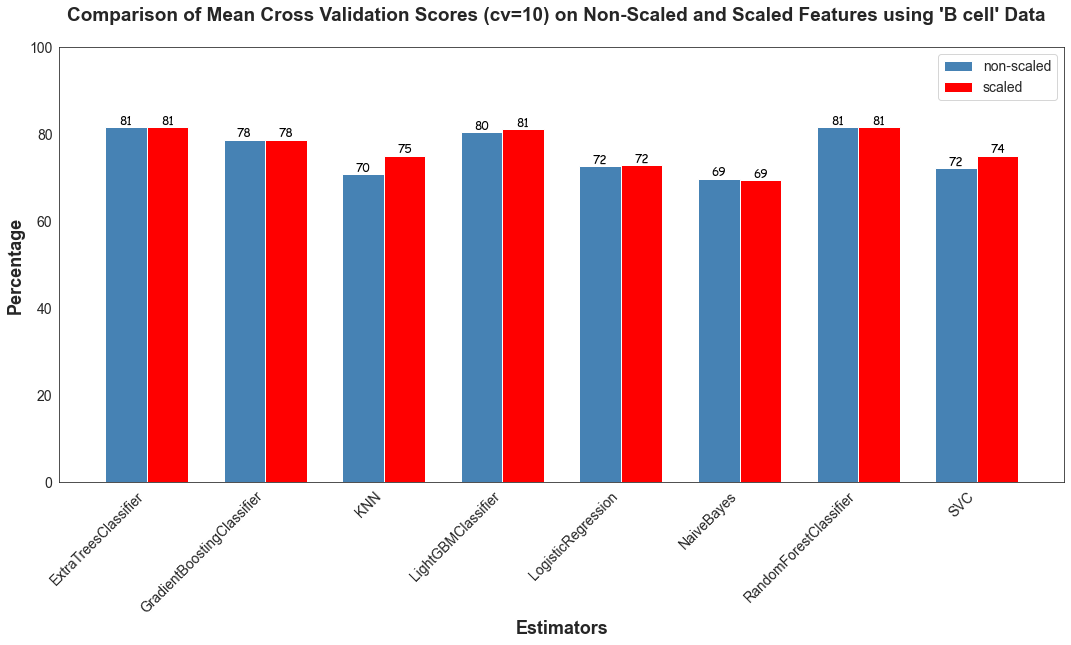

In [47]:
#Making bar graph displaying model performance on non-scaled and scaled features 
N = 8

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()


non_scaled_features=list_scores
bar1 = ax.bar(ind, non_scaled_features, width, color="steelblue")


scaled = scaledlist_scores
bar2 = ax.bar(ind + width, scaled, width, color='red')


ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("ExtraTreesClassifier", "GradientBoostingClassifier", 'KNN', 'LightGBMClassifier',
          'LogisticRegression', 'NaiveBayes', 'RandomForestClassifier', 'SVC'))

#ax.legend((bar1[0], bar2[0]), ('non-scaled', 'scaled'))



#making a function that displays height of each bar, which represents the mean cv score 
def label(values):
    for val in values:
        height = val.get_height()
        ax.text(val.get_x() + val.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom',
                fontsize=12, fontweight='normal', color='black', fontname='Comic Sans MS')
label(bar1)
label(bar2)

sns.set_style("white")

# Labeling axis and specifying ticks and y max limit
plt.suptitle("    Comparison of Mean Cross Validation Scores (cv=10) on Non-Scaled and Scaled Features using 'B cell' Data", 
          fontsize=19, weight='bold', y=0.95)

plt.xlabel("Estimators", fontsize=18,weight='bold')
plt.ylabel("Percentage", fontsize=18,weight='bold')

plt.legend(['non-scaled', 'scaled'],loc='upper right',prop={"size":14})

plt.xticks(rotation=45, horizontalalignment='right', 
           weight='normal', fontsize=14)
plt.yticks(weight='normal', fontsize=14)

plt.ylim(top=100) #setting y-axis limit value 



#setting size for figure
plt.gcf().set_size_inches(18, 8)

plt.show()

**After scaling the features, the cv scores for SVC and KNN improved by 2% and 5% respectively, while the treebased models' mean cv scores remained the same as expected.**

# Tuning estimators using GridSearchCV:
**I will be using GridSearchCV on the estimators that scores >=80% to get the optimal combination of hyperparameters that will result in better accuracy scores.**
* ExtraTreesClassifier (81%)
* RandomForestClassifier (81%)
* LightGBM(81%)
* GradientBoosting (78%)

**Then applying 10Fold Cross validation for evaluating model performance.**


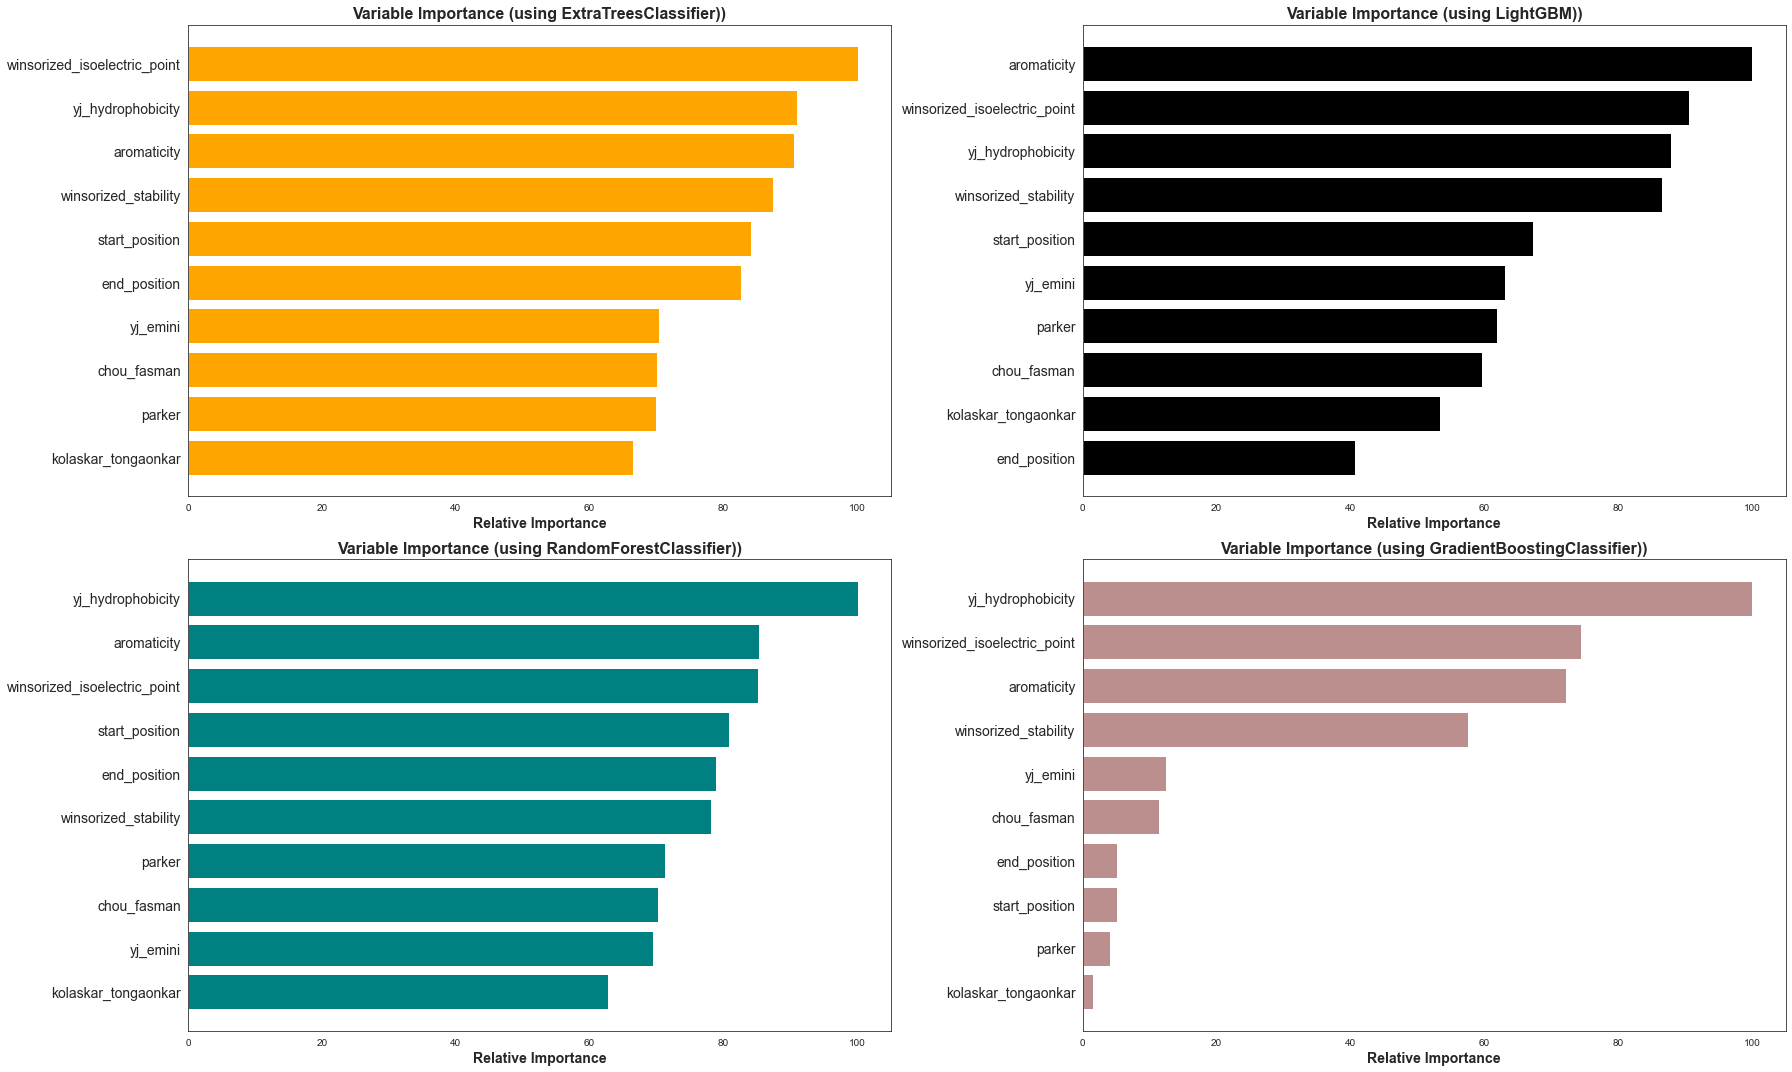

In [48]:
#Graphing the models' sensitivity to entropy  ("feature importance")

plt.figure(figsize=(25,15))


################################
#ExtraTreesClassifier
feature_importance_et = extratrees_clf.feature_importances_

# Make importances relative to max importance.
feature_importance_et = 100.0 * (feature_importance_et / feature_importance_et.max())
sorted_idx = np.argsort(feature_importance_et)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2, 2, 1)
plt.barh(pos, feature_importance_et[sorted_idx], align='center',color='orange')
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', weight='heavy', fontsize=14)
plt.title('Variable Importance (using ExtraTreesClassifier))', weight='heavy',  fontsize=16)


################################
#LightGBM
feature_importance_lgbm= lgbm.feature_importances_

# Make importances relative to max importance.
feature_importance_lgbm= 100.0 * (feature_importance_lgbm / feature_importance_lgbm.max())
sorted_idx = np.argsort(feature_importance_lgbm)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2, 2, 2)
plt.barh(pos, feature_importance_lgbm[sorted_idx], align='center', color='black')
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', weight='heavy', fontsize=14)
plt.title('Variable Importance (using LightGBM))', weight='heavy',  fontsize=16)

################################
#RandomForestClassifier
feature_importance_rf = rf_clf.feature_importances_

# Make importances relative to max importance.
feature_importance_rf= 100.0 * (feature_importance_rf / feature_importance_rf.max())
sorted_idx = np.argsort(feature_importance_rf)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2, 2, 3)
plt.barh(pos, feature_importance_rf[sorted_idx], align='center', color='teal')
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', weight='heavy', fontsize=14)
plt.title('Variable Importance (using RandomForestClassifier))', weight='heavy',  fontsize=16)



################################
#GradientBoostingClassifier
feature_importance_gb = gb_clf.feature_importances_

# Make importances relative to max importance.
feature_importance_gb = 100.0 * (feature_importance_gb / feature_importance_gb.max())
sorted_idx = np.argsort(feature_importance_gb)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(2, 2, 4)
plt.barh(pos, feature_importance_gb[sorted_idx], align='center',color='rosybrown')
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', weight='heavy', fontsize=14)
plt.title('Variable Importance (using GradientBoostingClassifier))', weight='heavy',  fontsize=16)



plt.tight_layout()
plt.show()

**Based on the estimators used, the feature variables vary in importance in determining their significance to the target variable. Next applying gridsearchcv to find best combination of parameters to optimize accuracy score for each estimator. After optimizing these estimators using  best_estimator attribute for model training. Model with best cv score will be used to determine feature importance.**

In [1]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,fontsize=20,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, weight='heavy')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=30, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=18)
    plt.show()

In [ ]:
%%time
#applying gridsearchcv on RandomForestClassifier


rf=RandomForestClassifier()
rf_parameters={'n_estimators':[100,500,1000],
            'max_features':['auto', 'sqrt', 'log2'],
            'max_depth':[None, 4,6,8],
            'criterion':['gini', 'entropy'],
                         "bootstrap":[True, False],
                         "random_state":[24]
                 }


rf_gscv=GridSearchCV(estimator=rf, 
                        param_grid=rf_parameters,
                        scoring="accuracy",
                        n_jobs=-1,
                        cv=5,
                        verbose=3)



#training model using train sets. 
rf_gscv.fit(X_train, y_train)

In [ ]:
#evaluating model performance and determining best combination of parameters to use
print(rf_gscv.best_score_, '\n')
print(rf_gscv.best_estimator_, '\n')
print(rf_gscv.best_params_, '\n')

In [50]:
#using attribute best_estimator 

randomforest_best_estimator={"bootstrap":False, 
                        "n_estimators":1000, 
                        "random_state":24
                       }

randomforestmodel=RandomForestClassifier(**randomforest_best_estimator)

#using whole dataset 
randomforestmodel.fit(X_train, y_train)

#making predictions 
randomforestmodel_test_pred=randomforestmodel.predict(X_test)
randomforestmodel_test_score=accuracy_score(y_test, randomforestmodel_test_pred)

print(f'Test Accuracy score: {randomforestmodel_test_score}')
print()



rf_cv_train=cross_validate(randomforestmodel, X_train, y_train,
                                    scoring='accuracy', cv=10, verbose=0)

rf_cv_test=cross_validate(randomforestmodel, X_test, y_test,
                                    scoring='accuracy', cv=10, verbose=0)



rf_cv_train_scores=rf_cv_train['test_score']
rf_mean_cv_train_score=np.mean(rf_cv_train_scores)
rf_mean_cv_train_percentage=rf_mean_cv_train_score*100
rf_cv_train_rounded=np.round(rf_mean_cv_train_percentage,2)

rf_cv_test_scores=rf_cv_test['test_score']
rf_mean_cv_test_score=np.mean(rf_cv_test_scores)
rf_mean_cv_percentage=rf_mean_cv_test_score*100
rf_cv_rounded=np.round(rf_mean_cv_percentage,2)


#gs_list_scores.append(rf_cv_rounded)
#gs_list_models.append('RandomForestClassifier')

print('RandomForestClassifier mean Cross Validate scores: ')
print('Mean cv score for the train data is: {:.3f}'.format(rf_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(rf_cv_rounded))


Test Accuracy score: 0.8693537178596248

RandomForestClassifier mean Cross Validate scores: 
Mean cv score for the train data is: 86.330
Mean cv score for the test data is: 82.110


In [51]:
#getting antibody valence count of y_test from bcell data 
# use for comparing the predictions that the models make.
bcell_data_y=y_test.value_counts()
bcell_data_y

0    2076
1     802
Name: target, dtype: int64

RandomForest Test accuracy score: 0.869



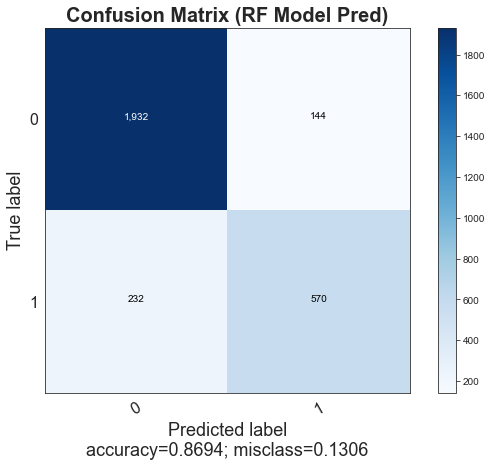

In [52]:
#Making predictions using the rf model 
rf_test_pred=randomforestmodel.predict(X_test)
rf_test_score=accuracy_score(y_test,rf_test_pred)

print('RandomForest Test accuracy score: {:.3f}'.format(rf_test_score))
print()

rf_test_cm=confusion_matrix(y_test, rf_test_pred, labels=[0,1])
plot_confusion_matrix(cm=rf_test_cm, target_names=[0, 1], title = 'Confusion Matrix (RF Model Pred)' ,normalize=False)

In [53]:
#setting prediction results to a df
randomforestmodel_test_pred_df=pd.DataFrame(randomforestmodel_test_pred,columns=['test_pred'])

#getting count of antibody valence count
randomforestmodel_test_pred_count=randomforestmodel_test_pred_df.value_counts()/len(X_test)*100


print(f'Antibody Valence prediction Percentage using test data (randomforestmodel):\n{randomforestmodel_test_pred_count}')

Antibody Valence prediction Percentage using test data (randomforestmodel):
test_pred
0            75.191105
1            24.808895
dtype: float64


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report


rf_report=classification_report(y_test, rf_test_pred, target_names=['0','1'])
print("RandomForest", rf_report)

RandomForest               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2076
           1       0.80      0.71      0.75       802

    accuracy                           0.87      2878
   macro avg       0.85      0.82      0.83      2878
weighted avg       0.87      0.87      0.87      2878



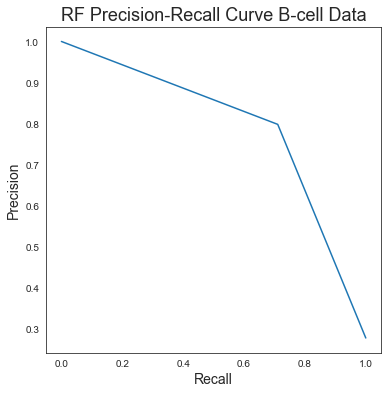

In [58]:
from sklearn.metrics import precision_recall_curve

pres, rec, thresholds = precision_recall_curve(y_test, rf_test_pred)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14)
plt.title('RF Precision-Recall Curve B-cell Data', fontsize=18)
plt.show()

### GridSearchCV LightGBM

In [ ]:
%%time
#applying gridsearchcv on RandomForestClassifier


lgbm=LGBMClassifier()
lgbm_parameters={'n_estimators':[100,500,1000],
                 "random_state":[24],
                 "boosting_type":['gbdt',"dart", "goss"],
                 "min_data_in_leaf":[20, 30, 50]
                }


lgbm_gscv=GridSearchCV(estimator=lgbm, 
                        param_grid=lgbm_parameters,
                        scoring="accuracy",
                        n_jobs=-1,
                        cv=5,
                        verbose=3)



#training model using all of the data so model can maximize learning before making predictions on new data  
lgbm_gscv.fit(X_train, y_train)

In [ ]:
print(lgbm_gscv.best_score_, '\n')
print(lgbm_gscv.best_estimator_, '\n')
print(lgbm_gscv.best_params_, '\n')

In [59]:
#using attribute best_estimator 

lgbm_model=LGBMClassifier(boosting_type="dart",
                         min_data_in_leaf=20,
                          n_estimators=1000, 
                          random_state=24)

#using whole dataset 
lgbm_model.fit(X_train, y_train)

#making predictions 
lgbm_test_pred=lgbm_model.predict(X_test)
lgbm_test_score=accuracy_score(y_test, lgbm_test_pred)

print(f'Test Accuracy score: {lgbm_test_score}')
print()



lgbm_cv_train=cross_validate(lgbm_model, X_train, y_train,
                                    scoring='accuracy', cv=10, verbose=0)

lgbm_cv_test=cross_validate(lgbm_model, X_test, y_test,
                                    scoring='accuracy', cv=10, verbose=0)



lgbm_cv_train_scores=lgbm_cv_train['test_score']
lgbm_mean_cv_train_score=np.mean(lgbm_cv_train_scores)
lgbm_mean_cv_train_percentage=lgbm_mean_cv_train_score*100
lgbm_cv_train_rounded=np.round(lgbm_mean_cv_train_percentage,2)

lgbm_cv_test_scores=lgbm_cv_test['test_score']
lgbm_mean_cv_test_score=np.mean(lgbm_cv_test_scores)
lgbm_mean_cv_percentage=lgbm_mean_cv_test_score*100
lgbm_cv_rounded=np.round(lgbm_mean_cv_percentage,2)


#gs_list_scores.append(lgbm_cv_rounded)
#gs_list_models.append('LGBMClassifier')

print('LGBM mean Cross Validate scores: ')
print('Mean cv score for the train data is: {:.3f}'.format(lgbm_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(lgbm_cv_rounded))

Test Accuracy score: 0.8509381514940931

LGBM mean Cross Validate scores: 
Mean cv score for the train data is: 85.050
Mean cv score for the test data is: 80.720


lgbm Test accuracy score: 0.851


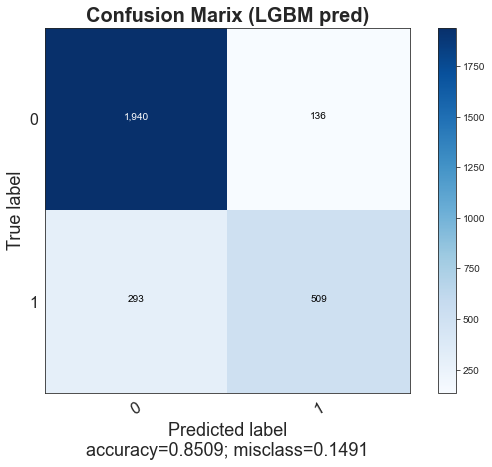

In [60]:
lgbm_test_pred=lgbm_model.predict(X_test)
lgbm_test_score=accuracy_score(y_test,lgbm_test_pred)


print('lgbm Test accuracy score: {:.3f}'.format(lgbm_test_score))

#confusion matrix for lgbm predictions 
lgbm_cm=confusion_matrix(y_test, lgbm_test_pred, labels=[0,1])

plot_confusion_matrix(cm=lgbm_cm, target_names=[0,1], title='Confusion Marix (LGBM pred)', normalize=False)

In [61]:
#setting prediction results to a df
lgbm_test_pred_df=pd.DataFrame(lgbm_test_pred,columns=['test_pred'])

#getting count of antibody valence count
lgbm_test_pred_count=lgbm_test_pred_df.value_counts()/len(X_test)*100



print(f'Antibody Valence prediction Percentage using test data (LGBM model):\n{lgbm_test_pred_count}')

Antibody Valence prediction Percentage using test data (LGBM model):
test_pred
0            77.588603
1            22.411397
dtype: float64


In [62]:
lgbm_report=classification_report(y_test, lgbm_test_pred, target_names=['0','1'])
print("LGBM", lgbm_report)

LGBM               precision    recall  f1-score   support

           0       0.87      0.93      0.90      2076
           1       0.79      0.63      0.70       802

    accuracy                           0.85      2878
   macro avg       0.83      0.78      0.80      2878
weighted avg       0.85      0.85      0.85      2878



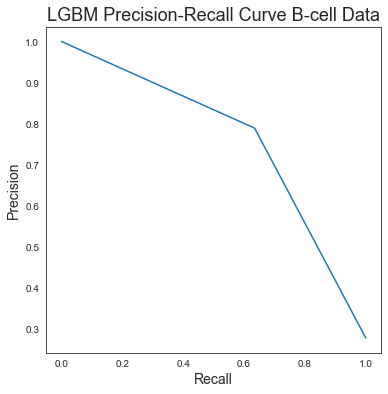

In [63]:
pres, rec, thresholds = precision_recall_curve(y_test, lgbm_test_pred)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14)
plt.title('LGBM Precision-Recall Curve B-cell Data', fontsize=18)
plt.show()

In [ ]:
%%time 
#applying gridsearchcv on ExtraTreesClassifier


et= ExtraTreesClassifier()

et_parameters={'n_estimators':[100,500,1000],
            'max_features':['auto', 'sqrt', 'log2'],
            'max_depth':[None, 4,6,8],
            'criterion':['gini', 'entropy'],
                  "bootstrap":[True, False],
                  "random_state":[24]
                 }


et_gscv=GridSearchCV(estimator=et, 
                        param_grid=et_parameters,
                        scoring="accuracy",
                        n_jobs=-1,
                        cv=5, 
                        verbose=3)


#training model 
et_gscv.fit(X_train, y_train )

In [ ]:
print(et_gscv.best_score_, '\n')
print(et_gscv.best_estimator_, '\n')
print(et_gscv.best_params_, '\n')

In [64]:
#using best_estimators on et model to predict on
extratreesmodel=RandomForestClassifier(n_estimators=1000, random_state=24)

#using whole dataset 
extratreesmodel.fit(X_train, y_train)

#making predictions 
extratrees_test_pred=extratreesmodel.predict(X_test)
extratrees_test_score=accuracy_score(y_test, extratrees_test_pred)

print(f'Test Accuracy score: {extratrees_test_score}')
print()


####################################################################
extratrees_cv_train_score=cross_validate(extratreesmodel, 
                                               X_train, y_train,
                                    scoring='accuracy', cv=10, verbose=0)

extratrees_cv_test_score=cross_validate(extratreesmodel, 
                                             X_test, y_test,
                                    scoring='accuracy', cv=10, verbose=0)



extratrees_cv_train_scores=extratrees_cv_train_score['test_score']
extratrees_mean_cv_train_score=np.mean(extratrees_cv_train_scores)
extratrees_mean_cv_train_percentage=extratrees_mean_cv_train_score*100
extratrees_cv_train_rounded=np.round(extratrees_mean_cv_train_percentage,2)



extratrees_cv_test_scores=extratrees_cv_test_score['test_score']
extratrees_mean_cv_test_score=np.mean(extratrees_cv_test_scores)
extratrees_mean_cv_percentage=extratrees_mean_cv_test_score*100
extratrees_cv_test_rounded=np.round(extratrees_mean_cv_percentage,2)



print('ExtraTreesClassifier mean Cross Validate scores: ')
print('Mean cv score for the train data is: {:.3f}'.format(extratrees_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(extratrees_cv_test_rounded))

Test Accuracy score: 0.8686587908269632

ExtraTreesClassifier mean Cross Validate scores: 
Mean cv score for the train data is: 86.300
Mean cv score for the test data is: 81.380


ET Test accuracy score: 0.869


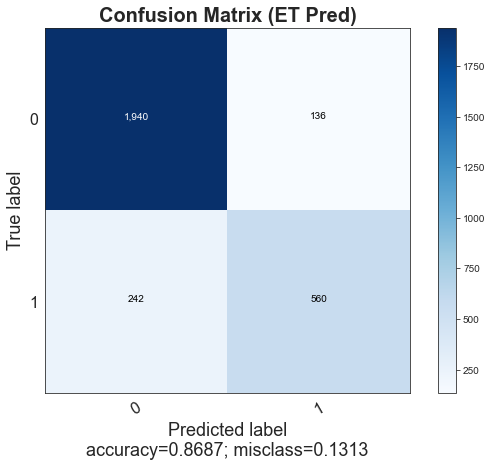

In [65]:
et_test_pred=extratreesmodel.predict(X_test)
et_test_score=accuracy_score(y_test,et_test_pred)


print('ET Test accuracy score: {:.3f}'.format(et_test_score))


#confusion matrix for et predictions 
et_cm=confusion_matrix(y_test, et_test_pred, labels=[0,1])

plot_confusion_matrix(cm=et_cm, target_names=[0,1], title='Confusion Matrix (ET Pred)', normalize=False)

In [66]:
#setting prediction results to a df
extratrees_test_pred_df=pd.DataFrame(extratrees_test_pred,columns=['test_pred'])

#getting count of antibody valence count
extratrees_test_pred_count=extratrees_test_pred_df.value_counts()/len(X_test)*100



print(f'Antibody Valence prediction count using test data (ExtraTreesClassifier model):\n{extratrees_test_pred_count}')

Antibody Valence prediction count using test data (ExtraTreesClassifier model):
test_pred
0            75.816539
1            24.183461
dtype: float64


In [67]:
et_report=classification_report(y_test, et_test_pred, target_names=['0','1'])
print("ExtraTrees", et_report)

ExtraTrees               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2076
           1       0.80      0.70      0.75       802

    accuracy                           0.87      2878
   macro avg       0.85      0.82      0.83      2878
weighted avg       0.87      0.87      0.87      2878



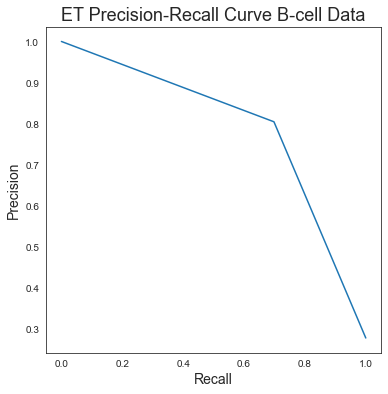

In [68]:
pres, rec, thresholds = precision_recall_curve(y_test, et_test_pred)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14)
plt.title('ET Precision-Recall Curve B-cell Data',fontsize=18)
plt.show()

In [ ]:
%%time 
#Applying GridSearchCV on GradientBoosting 

gb=ensemble.GradientBoostingClassifier(random_state=24)

#The default value of ‘friedman_mse’ is generally the best as it can provide a better approximation in some cases.
gb_parameters={'criterion':["friedman_mse", "mse", "mae"],
            'n_estimators':[100,500,1000],
            'max_features':[None, "sqrt","auto", "log2"],
            'max_depth':[3,5,6,7,8]
}

gb_gscv=GridSearchCV(estimator=gb,
                          param_grid=gb_parameters,
                   cv=5, n_jobs=-1, 
                        verbose=3)



gb_gscv.fit(X_train, y_train)



In [69]:
#using best_estimators on gb model to predict on new data


gradientboosting_model=ensemble.GradientBoostingClassifier(max_depth=10, 
                                             max_features=None, 
                                             n_estimators=1000, 
                                             random_state=24)

#using initial training sets 
gradientboosting_model.fit(X_train, y_train)

#making predictions 
gradientboosting_test_pred=gradientboosting_model.predict(X_test)
gradientboosting_test_score=accuracy_score(y_test, gradientboosting_test_pred)

print(f'Test Accuracy score: {gradientboosting_test_score}')
print()


#getting cv scores
gradientboosting_cv_train=cross_validate(gradientboosting_model, X_train, y_train,
                                    scoring='accuracy', cv=10, verbose=0)

gradientboosting_cv_test=cross_validate(gradientboosting_model, X_test, y_test,
                                    scoring='accuracy', cv=10, verbose=0)

gradientboosting_cv_train_scores=gradientboosting_cv_train['test_score']
gradientboosting_mean_cv_train_score=np.mean(gradientboosting_cv_train_scores)
gradientboosting_mean_cv_train_percentage=gradientboosting_mean_cv_train_score*100
gradientboosting_mean_cv_train_rounded=np.round(gradientboosting_mean_cv_train_percentage,2)

gradientboosting_cv_test_scores=gradientboosting_cv_test['test_score']
gradientboosting_mean_cv_test_score=np.mean(gradientboosting_cv_test_scores)
gradientboosting_mean_cv_test_percentage=gradientboosting_mean_cv_test_score*100
gradientboosting_mean_cv_test_rounded=np.round(gradientboosting_mean_cv_test_percentage,2)


print('GradientBoostingClassifier mean Cross Validate scores: ')
print('Mean cv score for the train data is: {:.3f}'.format(gradientboosting_mean_cv_train_rounded))
print('Mean cv score for the test data is: {:.3f}'.format(gradientboosting_mean_cv_test_rounded))

Test Accuracy score: 0.8627519110493398

GradientBoostingClassifier mean Cross Validate scores: 
Mean cv score for the train data is: 85.750
Mean cv score for the test data is: 81.450


GB Test accuracy score: 0.863


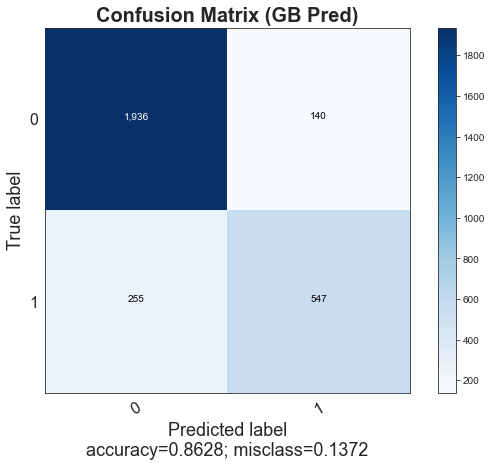

In [70]:
gb_test_pred=gradientboosting_model.predict(X_test)
gb_test_score=accuracy_score(y_test,gb_test_pred)


print('GB Test accuracy score: {:.3f}'.format(gb_test_score))

#confusion matrix for et predictions 
gb_cm=confusion_matrix(y_test, gb_test_pred, labels=[0,1])

plot_confusion_matrix(cm=gb_cm, target_names=[0,1], title='Confusion Matrix (GB Pred)', normalize=False)


In [71]:
#setting prediction results to a df
gradientboosting_test_pred_df=pd.DataFrame(gradientboosting_test_pred,columns=['test_pred'])

#getting count of antibody valence count
gradientboosting_test_pred_count=gradientboosting_test_pred_df.value_counts()/len(X_test)*100

print(f'Antibody Valence prediction count using test data (GradientBoostingClassifier model):\n{gradientboosting_test_pred_count}')

Antibody Valence prediction count using test data (GradientBoostingClassifier model):
test_pred
0            76.129256
1            23.870744
dtype: float64


In [72]:
gb_report=classification_report(y_test, gb_test_pred, target_names=['0','1'])
print("GradientBoosting", gb_report)

GradientBoosting               precision    recall  f1-score   support

           0       0.88      0.93      0.91      2076
           1       0.80      0.68      0.73       802

    accuracy                           0.86      2878
   macro avg       0.84      0.81      0.82      2878
weighted avg       0.86      0.86      0.86      2878



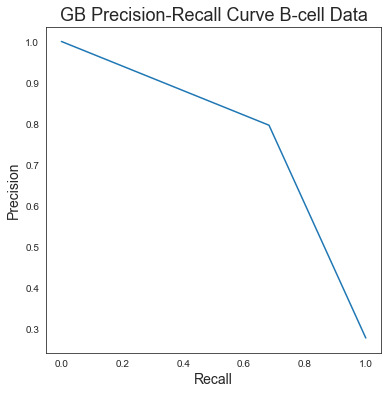

In [73]:
pres, rec, thresholds = precision_recall_curve(y_test, gb_test_pred)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14)
plt.title('GB Precision-Recall Curve B-cell Data', fontsize=18)
plt.show()

In [74]:
#displaying all classification report

print("ExtraTrees", et_report)
print()
print()


print("GradientBoosting", gb_report)
print()
print()


print("LGBM", lgbm_report)
print()
print()


print("RandomForest", rf_report)

ExtraTrees               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2076
           1       0.80      0.70      0.75       802

    accuracy                           0.87      2878
   macro avg       0.85      0.82      0.83      2878
weighted avg       0.87      0.87      0.87      2878



GradientBoosting               precision    recall  f1-score   support

           0       0.88      0.93      0.91      2076
           1       0.80      0.68      0.73       802

    accuracy                           0.86      2878
   macro avg       0.84      0.81      0.82      2878
weighted avg       0.86      0.86      0.86      2878



LGBM               precision    recall  f1-score   support

           0       0.87      0.93      0.90      2076
           1       0.79      0.63      0.70       802

    accuracy                           0.85      2878
   macro avg       0.83      0.78      0.80      2878
weighted avg       0.85      0.85    

In [75]:
#making empty lists to use for graphical representaion for estimators used in gridsearchcv test data 
gs_list_models=[]
gs_list_scores=[]

gs_list_scores.append(extratrees_cv_test_rounded)
gs_list_models.append('ExtraTreesClassifier')

gs_list_scores.append(gradientboosting_mean_cv_test_rounded)
gs_list_models.append('GradientBoostingClassifier')

gs_list_scores.append(lgbm_cv_rounded)
gs_list_models.append('LGBMClassifier')

gs_list_scores.append(rf_cv_rounded)
gs_list_models.append('RandomForestClassifier')

In [76]:
#making empty lists for estimators used in gridsearchcv train data 
gs_train_scores=[]


gs_train_scores.append(extratrees_cv_train_rounded)

gs_train_scores.append(gradientboosting_mean_cv_train_rounded)

gs_train_scores.append(lgbm_cv_train_rounded)

gs_train_scores.append(rf_cv_train_rounded)

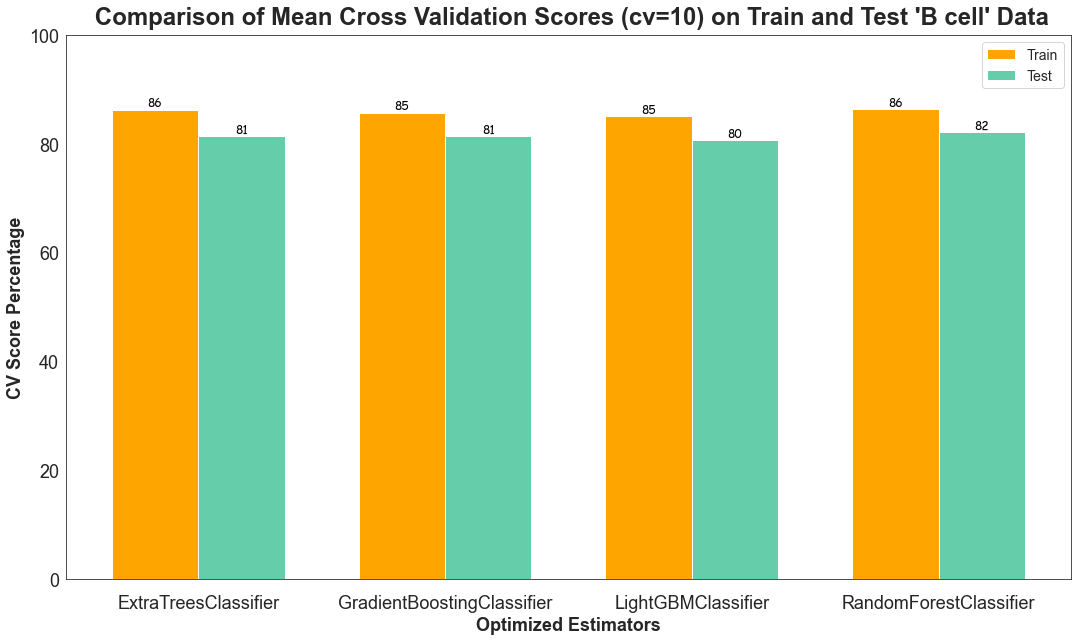

In [79]:
N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
sns.set_style("white")

#non-scaled features 
estimators=gs_train_scores
bar1 = ax.bar(ind, estimators, width, color='orange')


optimized_estimators=gs_list_scores
bar2 = ax.bar(ind + width, optimized_estimators, width, color='mediumaquamarine')


# add some text for labels, title and axes ticks
#ax.set_ylabel('Percentage')
#ax.set_title('Estimators')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("ExtraTreesClassifier", "GradientBoostingClassifier", 'LightGBMClassifier',
                    'RandomForestClassifier'))



#making a function that displays height of each bar, which represents the mean cv score 
def label(values):
    for val in values:
        height = val.get_height()
        ax.text(val.get_x() + val.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom',
                fontsize=12, fontweight='normal', color='black', fontname='Comic Sans MS')
label(bar1)
label(bar2)



# Labeling axis and specifying ticks and y max limit
plt.suptitle("      Comparison of Mean Cross Validation Scores (cv=10) on Train and Test 'B cell' Data", 
              y=0.92,fontsize=24, weight='bold')


plt.xlabel("Optimized Estimators", fontsize=18,weight='bold')
plt.ylabel("CV Score Percentage", fontsize=18, weight='bold')

plt.legend(['Train', "Test"],loc='upper right',prop={"size":14})

plt.xticks(rotation=0, horizontalalignment='center', 
           weight='normal', fontsize=18, y=-0.015)
plt.yticks(weight='normal', fontsize=18)

plt.ylim(top=100) #setting y-axis limit value 



#setting size for figure
plt.gcf().set_size_inches(18, 10)

plt.show()

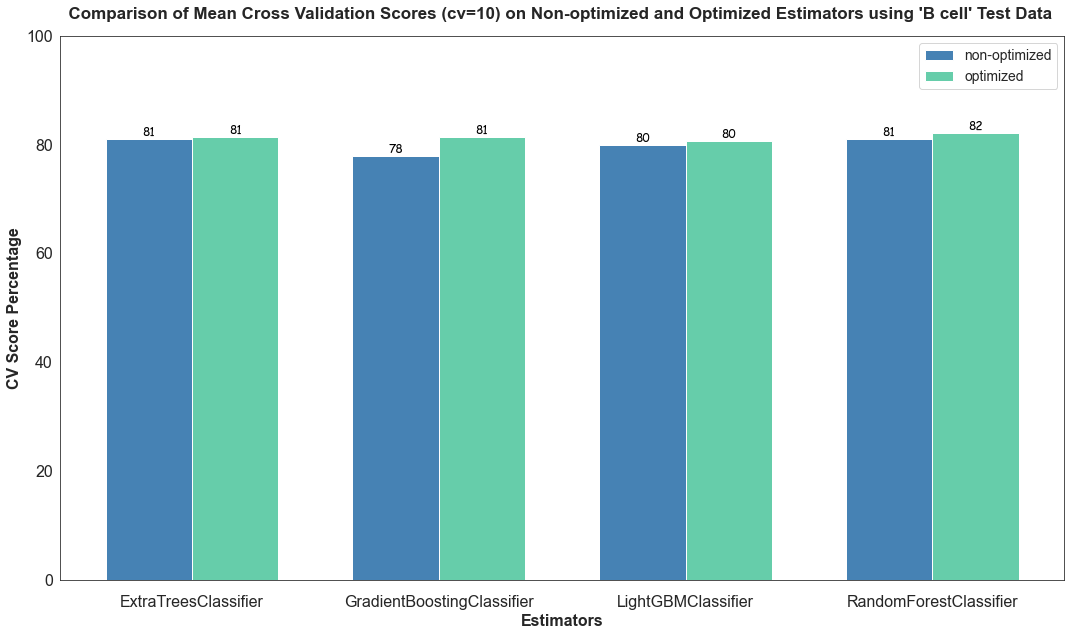

In [80]:
N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
sns.set_style("white")

#non-scaled features 
estimators=(81, 78, 80, 81)
bar1 = ax.bar(ind, estimators, width, color='steelblue')


optimized_estimators=gs_list_scores
bar2 = ax.bar(ind + width, optimized_estimators, width, color='mediumaquamarine')


# add some text for labels, title and axes ticks
#ax.set_ylabel('Percentage')
#ax.set_title('Estimators')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("ExtraTreesClassifier", "GradientBoostingClassifier", 'LightGBMClassifier',
                    'RandomForestClassifier'))



#making a function that displays height of each bar, which represents the mean cv score 
def label(values):
    for val in values:
        height = val.get_height()
        ax.text(val.get_x() + val.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom',
                fontsize=12, fontweight='normal', color='black', fontname='Comic Sans MS')
label(bar1)
label(bar2)



# Labeling axis and specifying ticks and y max limit
plt.suptitle("      Comparison of Mean Cross Validation Scores (cv=10) on Non-optimized and Optimized Estimators using 'B cell' Test Data", 
              y=0.92,fontsize=17, weight='bold')


plt.xlabel("Estimators", fontsize=16,weight='bold')
plt.ylabel("CV Score Percentage", fontsize=16, weight='bold')

plt.legend(['non-optimized', "optimized"],loc='upper right',prop={"size":14})

plt.xticks(rotation=0, horizontalalignment='center', 
           weight='normal', fontsize=16, y=-0.015)
plt.yticks(weight='normal', fontsize=16)

plt.ylim(top=100) #setting y-axis limit value 



#setting size for figure
plt.gcf().set_size_inches(18, 10)

plt.show()

**The estimators improved with application of best_estimator evaluated by gridsearchcv. The estimator that performed the best based on mean cv score is RF model.**

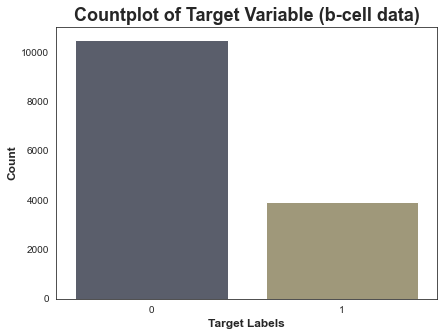

Bcell data: Percentage of antibody valence:
0    72.878293
1    27.121707
Name: target, dtype: float64

-----------------------------------------------------------------------------------------------
ExtraTreesClassifier: 
Antibody Valence prediction count using test data (ExtraTreesClassifier model):
test_pred
0            75.816539
1            24.183461
dtype: float64

GradientBoostingClassifier: 
Antibody Valence prediction count using test data (GradientBoostingClassifier model):
test_pred
0            76.129256
1            23.870744
dtype: float64

LGBM: 
Antibody Valence prediction count using test data (LGBM model):
test_pred
0            77.588603
1            22.411397
dtype: float64

RandomForestClassifier:
Antibody Valence prediction count using test data (randomforestmodel):
test_pred
0            75.191105
1            24.808895
dtype: float64



In [81]:
#counting target variable values for bcell data 
plt.figure(figsize=(15,5))
sns.set_style("white")

plt.subplot(1,2,1)
sns.countplot(data=bcell_data, x='target', palette='cividis')
plt.title("Countplot of Target Variable (b-cell data)", fontsize=18, weight='heavy')
plt.ylabel("Count", fontsize=12, weight='heavy')
plt.xlabel("Target Labels", fontsize=12, weight='heavy')
plt.show()

#getting percentage on how many + and - for antibody valence there are 
percentage_count=bcell_data['target'].value_counts()/len(bcell_data)*100.0
print(f'Bcell data: Percentage of antibody valence:\n{percentage_count}')
print()
print("-----------------------------------------------------------------------------------------------")
print("ExtraTreesClassifier: ")
print(f'Antibody Valence prediction count using test data (ExtraTreesClassifier model):\n{extratrees_test_pred_count}')
print()

print("GradientBoostingClassifier: ")
print(f'Antibody Valence prediction count using test data (GradientBoostingClassifier model):\n{gradientboosting_test_pred_count}')
print()

print("LGBM: ")
print(f'Antibody Valence prediction count using test data (LGBM model):\n{lgbm_test_pred_count}')
print()

print("RandomForestClassifier:")
print(f'Antibody Valence prediction count using test data (randomforestmodel):\n{randomforestmodel_test_pred_count}')
print()

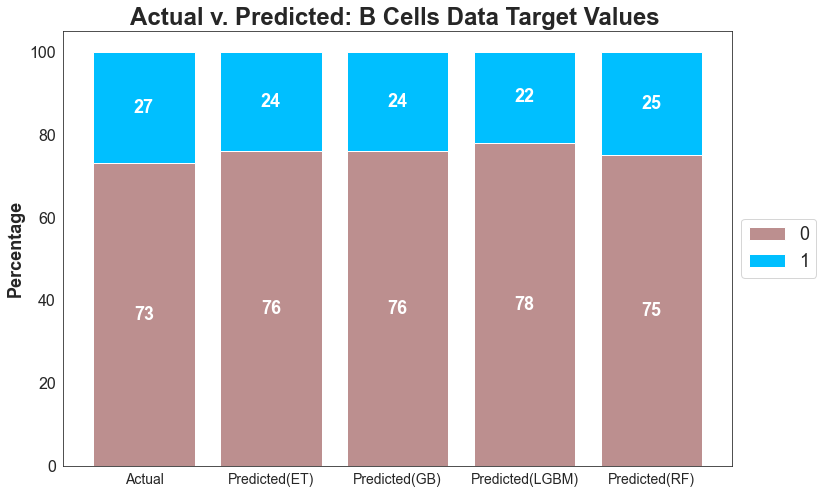

In [82]:
# stacked bar plot
sns.set_style("white")

#Get values from the group and categories
var_labels = ["Actual", "Predicted(ET)", "Predicted(GB)", "Predicted(LGBM)", "Predicted(RF)"]
neg_av= [73, 76, 76, 78, 75]
pos_av = [27, 24, 24, 22, 25]

    
#add colors
colors = ['rosybrown', '#00BFFF']
# The position of the bars on the x-axis
r = range(len(var_labels))
barWidth = 0.8
#plot bars
plt.figure(figsize=(12,8))
ax1 = plt.bar(r, neg_av, color=colors[0], edgecolor='white', width=barWidth, label="0")
ax2 = plt.bar(r, pos_av, bottom=np.array(neg_av), color=colors[1], edgecolor='white', width=barWidth, label='1')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(r, var_labels, fontweight='bold', fontsize=18)
plt.ylabel("Percentage", fontweight='bold', fontsize=18)
plt.title("Actual v. Predicted: B Cells Data Target Values ", fontweight='bold', fontsize=24)
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
plt.savefig("stacked2.png")

plt.xticks(rotation=0, horizontalalignment='center', weight='normal', fontsize=14)
plt.show()
# You can replace "%d" % h1 with "{}".format(h1)

**Since the ` RandomForestClassifier` has the best mean cv score of 82% means that it is the best estimator, therefore using its feature importance results**

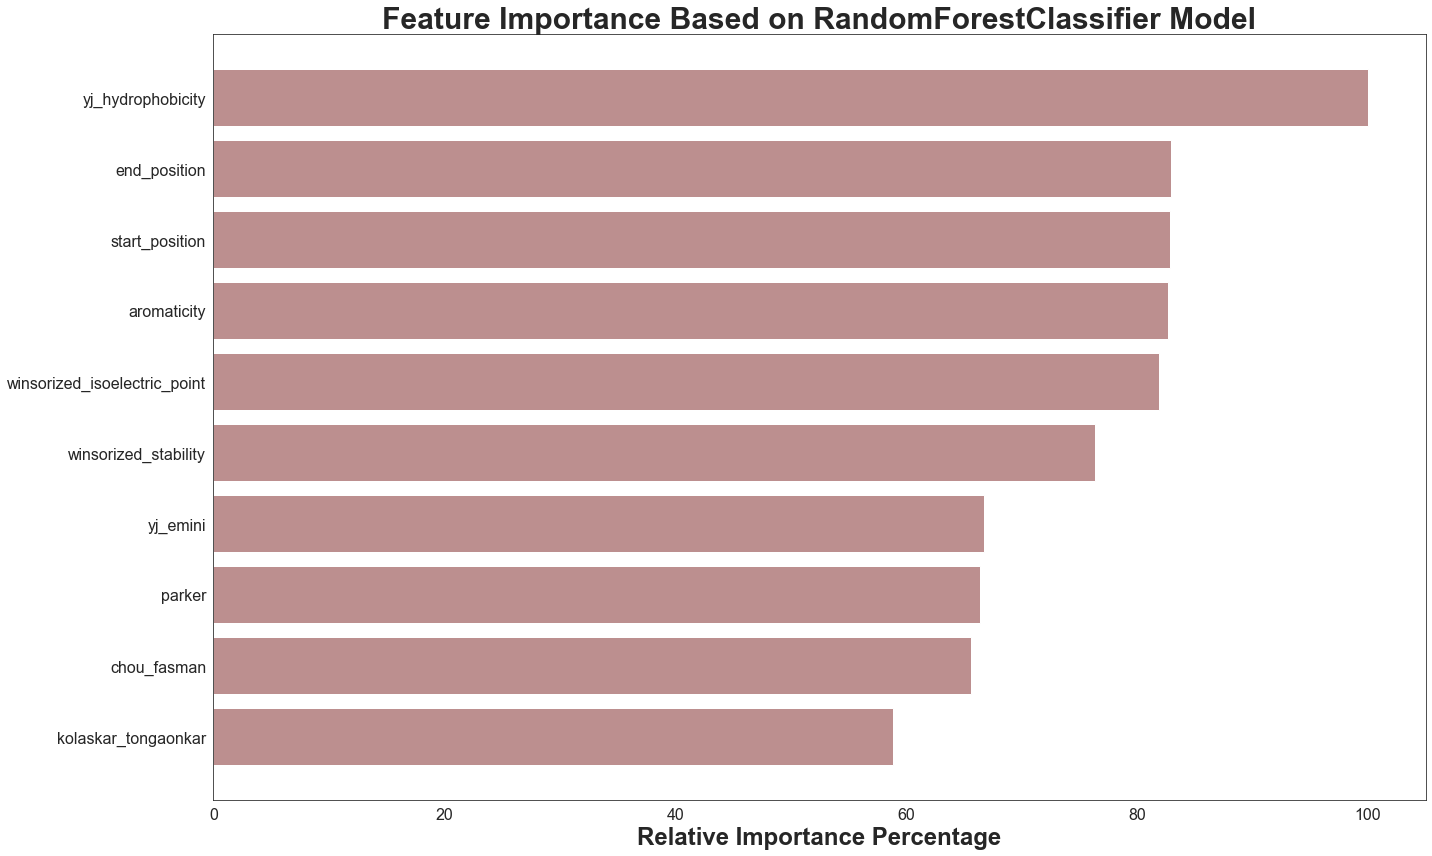

In [83]:
#Graphing the estimators' evaluation on feature importance wrt to target variable 

plt.figure(figsize=(20,12))
sns.set_style("white")



################################
#RandomForestClassifier
feature_importance_randomforestmodel = randomforestmodel.feature_importances_

# Make importances relative to max importance.
feature_importance_randomforestmodel= 100.0 * (feature_importance_randomforestmodel / feature_importance_randomforestmodel.max())
sorted_idx = np.argsort(feature_importance_randomforestmodel)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance_randomforestmodel[sorted_idx], align='center', color="rosybrown")
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Relative Importance Percentage', weight='heavy', fontsize=24)
plt.title('Feature Importance Based on RandomForestClassifier Model', weight='heavy', fontsize=30)





plt.tight_layout()
plt.show()

**From the output produced by RandomForestClassifier, the features that conveys most information about the target are hydrophobicity, end_position, start_position', 'aromaticity', and 'isoelctric_point'.**

# Predicting on two new datasets:

1. sars_data (has target column) 
2. covid dataset  (no target column) 

In [84]:
X_sars=sars_data.drop(['target','parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1)
y_sars=sars_data['target']



X_train_sars, X_test_sars, y_train_sars, y_test_sars=train_test_split(X_sars, y_sars,
                                                  test_size=0.2,
                                                  random_state=24)

print(X_sars.shape)
print(len(y_sars))

(520, 10)
520


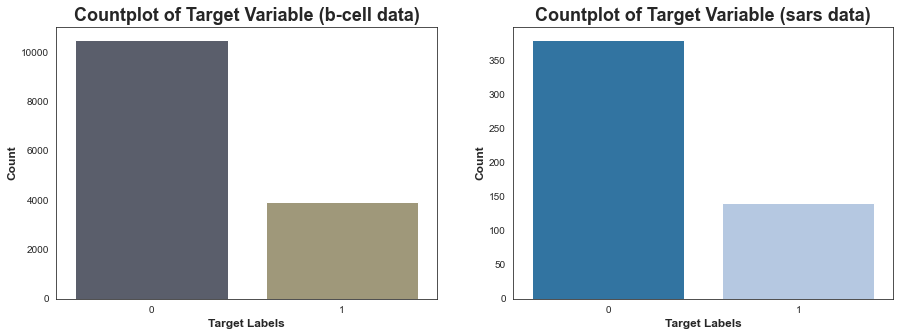

Bcell data: Percentage of antibody valence:
0    72.878293
1    27.121707
Name: target, dtype: float64

Sars data: Percentage of antibody valence:
0    73.076923
1    26.923077
Name: target, dtype: float64


In [85]:
#counting target variable values for bcell data 
plt.figure(figsize=(15,5))
sns.set_style("white")

plt.subplot(1,2,1)
sns.countplot(data=bcell_data, x='target', palette='cividis')
plt.title("Countplot of Target Variable (b-cell data)", fontsize=18, weight='heavy')
plt.ylabel("Count", fontsize=12, weight='heavy')
plt.xlabel("Target Labels", fontsize=12, weight='heavy')


#counting target variable values on the sars_data 
plt.subplot(1,2,2)
sns.countplot(data=sars_data, x='target', palette='tab20')
plt.title("Countplot of Target Variable (sars data)", fontsize=18, weight='heavy')
plt.ylabel("Count", fontsize=12, weight='heavy')
plt.xlabel("Target Labels", fontsize=12, weight='heavy')
plt.show()




#getting percentage on how many + and - for antibody valence there are on both bcell and sars data
percentage_count=bcell_data['target'].value_counts()/len(bcell_data)*100.0
print(f'Bcell data: Percentage of antibody valence:\n{percentage_count}')
print()
percentage_count=sars_data['target'].value_counts()/len(sars_data)*100.0
print(f'Sars data: Percentage of antibody valence:\n{percentage_count}')

* Like the bcell data, there is a class imbalance on the sars_data as the target labels are not evenly distributed.

* The bcell data represents the sars data well as they are very close in negative antibody valence values at ~70% and positive value at ~30%.

In [86]:
#counting SARS target data to use for comparing what the models predict
sars_count=sars_data['target'].value_counts()
print(f'Sars data: Count of antibody valence:\n{sars_count}')

Sars data: Count of antibody valence:
0    380
1    140
Name: target, dtype: int64


In [87]:
#using extratreesmodel to predict on sar_data


#using the whole bcell_dataset to train model in
extratreesmodel.fit(X, y)

#making predictions on new data 
extratrees_pred_sars=extratreesmodel.predict(X_sars)

#evaluating accuracy score: 
et_test_score_sars=accuracy_score(y_sars, extratrees_pred_sars)

print(f'Test Accuracy score: {et_test_score_sars}')
print()


#evaluating cv score 
et_sars_cv=cross_validate(extratreesmodel,X_sars, y_sars,
                                    scoring='accuracy', cv=10, verbose=0)

et_cv_test_scores=et_sars_cv['test_score']
et_mean_cv_test_score=np.mean(et_cv_test_scores)
et_mean_cv_test_percentage=et_mean_cv_test_score*100
et_mean_cv_test_rounded=np.round(et_mean_cv_test_percentage,2)

print('Accuracy scores for the ten folds: \n', et_cv_test_scores)

print()
print(f'ET mean Cross Validate scores using the sars_data: {et_mean_cv_test_rounded} ')

Test Accuracy score: 0.4673076923076923

Accuracy scores for the ten folds: 
 [0.73076923 0.65384615 0.53846154 0.53846154 0.28846154 0.17307692
 0.28846154 0.53846154 0.55769231 0.73076923]

ET mean Cross Validate scores using the sars_data: 50.38 


In [89]:
#setting prediction results to a df
et_sars_predict_df=pd.DataFrame(extratrees_pred_sars,columns=['ET_prediction'])

#getting count of antibody valence count
et_pred_sars=et_sars_predict_df.value_counts()/len(X_sars)*100

print(f'Antibody Valence prediction count using ExtraTrees model:\n{et_pred_sars}')

Antibody Valence prediction count using ExtraTrees model:
ET_prediction
1                62.5
0                37.5
dtype: float64


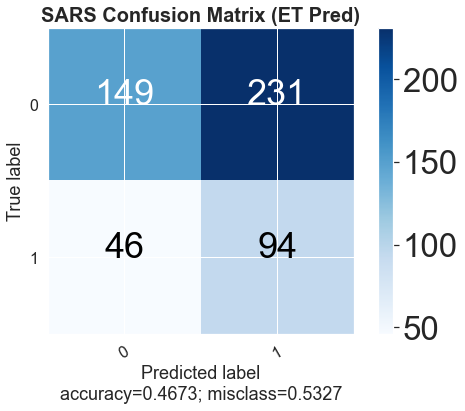

In [95]:
#confusion matrix for gb predictions on SARS dataset
et_cm=confusion_matrix(y_sars, extratrees_pred_sars, labels=[0,1])

plot_confusion_matrix(cm=et_cm, target_names=[0,1], title='SARS Confusion Matrix (ET Pred)', normalize=False)

In [91]:
#using gradientboostingmodel to predict on sar_data


#using the whole bcell_dataset to train model in
gradientboosting_model.fit(X, y)

#making predictions on new data 
gb_pred_sars=gradientboosting_model.predict(X_sars)

#evaluating accuracy score: 
gb_test_score_sars=accuracy_score(y_sars, gb_pred_sars)

print(f'Test Accuracy score: {gb_test_score_sars}')
print()


#evaluating cv score 
gradientboosting_sars_cv=cross_validate(gradientboosting_model,X_sars, y_sars,
                                    scoring='accuracy', cv=10, verbose=0)

gradientboosting_cv_test_scores=gradientboosting_sars_cv['test_score']
gradientboosting_mean_cv_test_score=np.mean(gradientboosting_cv_test_scores)
gradientboosting_mean_cv_test_percentage=gradientboosting_mean_cv_test_score*100
gradientboosting_mean_cv_test_rounded=np.round(gradientboosting_mean_cv_test_percentage,2)

print('Accuracy scores for the ten folds: \n', gradientboosting_cv_test_scores)

print()

print(f'GradientBoostingClassifier mean Cross Validate scores using the sars_data: {gradientboosting_mean_cv_test_rounded} ')

Test Accuracy score: 0.4826923076923077

Accuracy scores for the ten folds: 
 [0.73076923 0.61538462 0.55769231 0.48076923 0.44230769 0.44230769
 0.30769231 0.48076923 0.55769231 0.73076923]

GradientBoostingClassifier mean Cross Validate scores using the sars_data: 53.46 


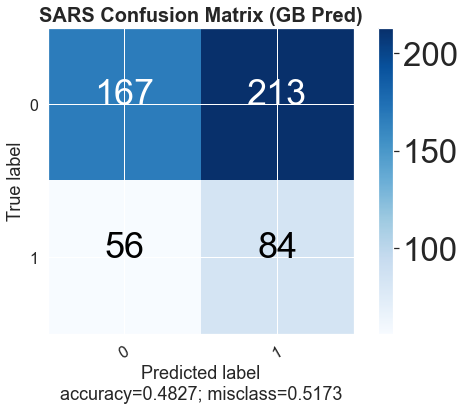

In [92]:
#confusion matrix for gb predictions on SARS dataset
gb_cm=confusion_matrix(y_sars, gb_pred_sars, labels=[0,1])

plot_confusion_matrix(cm=gb_cm, target_names=[0,1], title='SARS Confusion Matrix (GB Pred)', normalize=False)

In [96]:
#setting prediction results to a df
gradientboosting_sars_pred_df=pd.DataFrame(gb_pred_sars,columns=['gb_pred'])

#getting count of antibody valence count
gradientboosting_pred_sars=gradientboosting_sars_pred_df.value_counts()/len(X_sars)*100



print(f'Antibody Valence prediction count using GradientBoostingClassifier model:\n{gradientboosting_pred_sars}')

Antibody Valence prediction count using GradientBoostingClassifier model:
gb_pred
1          57.115385
0          42.884615
dtype: float64


In [97]:
#using lgbm_model to predict on sar_data

#using the whole bcell_dataset to train model in
lgbm_model.fit(X, y)

#making predictions on new data 
lgbm_pred_sars=lgbm_model.predict(X_sars)

#evaluating accuracy score: 
lgbm_test_score_sars=accuracy_score(y_sars, lgbm_pred_sars)

print(f'Test Accuracy score: {lgbm_test_score_sars}')
print()


#evaluating cv score 
lgbm_sars_cv=cross_validate(lgbm_model,X_sars, y_sars,
                                    scoring='accuracy', cv=10, verbose=0)

lgbm_cv_test_scores=lgbm_sars_cv['test_score']
lgbm_mean_cv_test_score=np.mean(lgbm_cv_test_scores)
lgbm_mean_cv_test_percentage=lgbm_mean_cv_test_score*100
lgbm_mean_cv_test_rounded=np.round(lgbm_mean_cv_test_percentage,2)

print('Accuracy scores for the ten folds: \n', lgbm_cv_test_scores)

print()

print(f'LGBM mean Cross Validate scores using the sars_data: {lgbm_mean_cv_test_rounded} ')

Test Accuracy score: 0.4807692307692308

Accuracy scores for the ten folds: 
 [0.73076923 0.44230769 0.67307692 0.40384615 0.21153846 0.28846154
 0.25       0.40384615 0.48076923 0.73076923]

LGBM mean Cross Validate scores using the sars_data: 46.15 


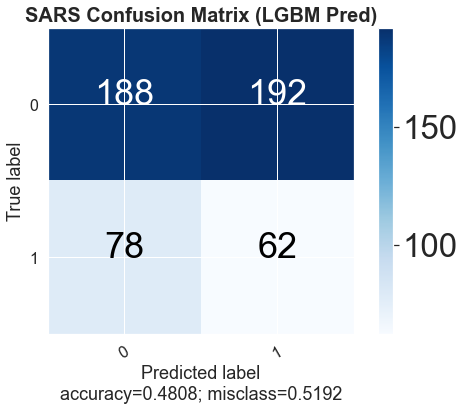

In [98]:
#confusion matrix for lgbm predictions on SARS dataset
lgbm_cm=confusion_matrix(y_sars, lgbm_pred_sars, labels=[0,1])

plot_confusion_matrix(cm=lgbm_cm, target_names=[0,1], title='SARS Confusion Matrix (LGBM Pred)', normalize=False)

In [99]:
#setting prediction results to a df
lgbm_sars_pred_df=pd.DataFrame(lgbm_pred_sars,columns=['lgbm_pred'])

#getting count of antibody valence count
lgbm_pred_sars_count=lgbm_sars_pred_df.value_counts()/len(X_sars)*100

print(f'Antibody Valence prediction count using LGBM model:\n{lgbm_pred_sars_count}')

Antibody Valence prediction count using LGBM model:
lgbm_pred
0            51.153846
1            48.846154
dtype: float64


In [100]:
#using rf model 
randomforestmodel.fit(X, y)


#making predictions on new data 
randomforestmodel_pred_sars=randomforestmodel.predict(X_sars)

#evaluating accuracy score: 
randomforestmodel_test_score_sars=accuracy_score(y_sars, randomforestmodel_pred_sars)

print(f'Test Accuracy score: {randomforestmodel_test_score_sars}')
print()


#evaluating cv score 
randomforestmodel_sars_cv=cross_validate(randomforestmodel,X_sars, y_sars,
                                    scoring='accuracy', cv=10, verbose=0)

randomforestmodel_cv_test_scores=randomforestmodel_sars_cv['test_score']
randomforestmodel_mean_cv_test_score=np.mean(randomforestmodel_cv_test_scores)
randomforestmodel_mean_cv_test_percentage=randomforestmodel_mean_cv_test_score*100
randomforestmodel_mean_cv_test_rounded=np.round(randomforestmodel_mean_cv_test_percentage,2)

print('Accuracy scores for the ten folds: \n', randomforestmodel_cv_test_scores)

print()


print(f'RandomForest model mean Cross Validate scores using the sars_data: {randomforestmodel_mean_cv_test_rounded} ')

Test Accuracy score: 0.46923076923076923

Accuracy scores for the ten folds: 
 [0.73076923 0.61538462 0.42307692 0.34615385 0.25       0.07692308
 0.25       0.34615385 0.32692308 0.73076923]

RandomForest model mean Cross Validate scores using the sars_data: 40.96 


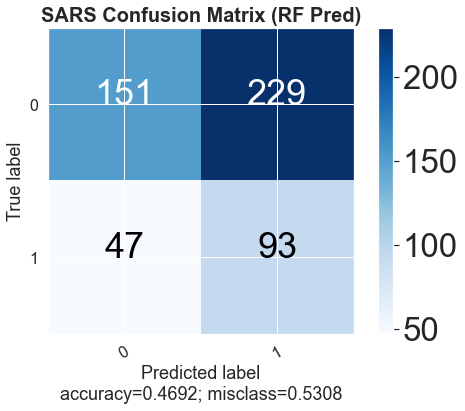

In [101]:
#confusion matrix for RF predictions on SARS dataset
rf_cm=confusion_matrix(y_sars, randomforestmodel_pred_sars, labels=[0,1])

plot_confusion_matrix(cm=rf_cm, target_names=[0,1], title='SARS Confusion Matrix (RF Pred)', normalize=False)

In [102]:
#setting prediction results to a df
randomforestmodel_sars_pred_df=pd.DataFrame(randomforestmodel_pred_sars,columns=['lgbm_pred'])

#getting count of antibody valence count
randomforestmodel_pred_sars_percentage=randomforestmodel_sars_pred_df.value_counts()/len(X_sars)*100


print(f'Antibody Valence prediction count using randomforestmodel model:\n{randomforestmodel_pred_sars_percentage}')

Antibody Valence prediction count using randomforestmodel model:
lgbm_pred
1            61.923077
0            38.076923
dtype: float64


### Notes on Accuracy, Precision, Recall, F-score

* Accuracy is a value that your model correctly classified.
* Precision is a value that tells you what proportion of positive predictions are correct.
* Recall is a value that tells you what proportion of instances in the positive class were correctly predicted. This is a good indication of how many positive instances are being missed.
* F-score: When evaluating classifiers, it is convenient to combine the precision and recall into a single value called the F-score (also called the F1 score). Use the F-score to see how the two metrics level out when combined.

In [103]:
et_precision = precision_score(y_sars, extratrees_pred_sars)
et_precision=et_precision*100
et_precision=np.round(et_precision,2)
print('ET Precision: ' , et_precision)
print()

gb_precision=precision_score(y_sars, gb_pred_sars)
gb_precision=gb_precision*100
gb_precision=np.round(gb_precision,2)
print('GB Precision: ', gb_precision)
print()

lgbm_precision = precision_score(y_sars, lgbm_pred_sars)
lgbm_precision=lgbm_precision*100
lgbm_precision=np.round(lgbm_precision,2)
print('LGBM Precision: ' , lgbm_precision)
print()


rf_precision=precision_score(y_sars, randomforestmodel_pred_sars)
rf_precision=rf_precision*100
rf_precision=np.round(rf_precision,2)
print('RF Precision:', rf_precision)
print()



ET Precision:  28.92

GB Precision:  28.28

LGBM Precision:  24.41

RF Precision: 28.88



In [104]:
#making empty lists to use for graphical representation for estimators used in SARS prediction
sars_preds=[]

sars_preds.append(et_precision)
sars_preds.append(gb_precision)
sars_preds.append(lgbm_precision)
sars_preds.append(rf_precision)

In [105]:
et_report=classification_report(y_sars, extratrees_pred_sars, target_names=['0','1'])
print("ExtraTrees", et_report)
print()
print()

gb_report=classification_report(y_sars, gb_pred_sars, target_names=['0','1'])
print("GradientBoosting", gb_report)
print()
print()

lgbm_report=classification_report(y_sars, lgbm_pred_sars, target_names=['0','1'])
print("LGBM", lgbm_report)
print()
print()

rf_report=classification_report(y_sars, randomforestmodel_pred_sars, target_names=['0','1'])
print("RandomForest", rf_report)

ExtraTrees               precision    recall  f1-score   support

           0       0.76      0.39      0.52       380
           1       0.29      0.67      0.40       140

    accuracy                           0.47       520
   macro avg       0.53      0.53      0.46       520
weighted avg       0.64      0.47      0.49       520



GradientBoosting               precision    recall  f1-score   support

           0       0.75      0.44      0.55       380
           1       0.28      0.60      0.38       140

    accuracy                           0.48       520
   macro avg       0.52      0.52      0.47       520
weighted avg       0.62      0.48      0.51       520



LGBM               precision    recall  f1-score   support

           0       0.71      0.49      0.58       380
           1       0.24      0.44      0.31       140

    accuracy                           0.48       520
   macro avg       0.48      0.47      0.45       520
weighted avg       0.58      0.48    

In [113]:
#making empty lists to use for graphical representaion for estimators used in sars prediction
sars_list_models=[]
sars_list_scores=[]

sars_list_scores.append(et_mean_cv_test_rounded)
sars_list_models.append('ExtraTrees')

sars_list_scores.append(gradientboosting_mean_cv_test_rounded)
sars_list_models.append('Gradient Boosting')

sars_list_scores.append(lgbm_mean_cv_test_rounded)
sars_list_models.append('LGBM')



sars_list_scores.append(randomforestmodel_mean_cv_test_rounded)
sars_list_models.append('Random Forest')



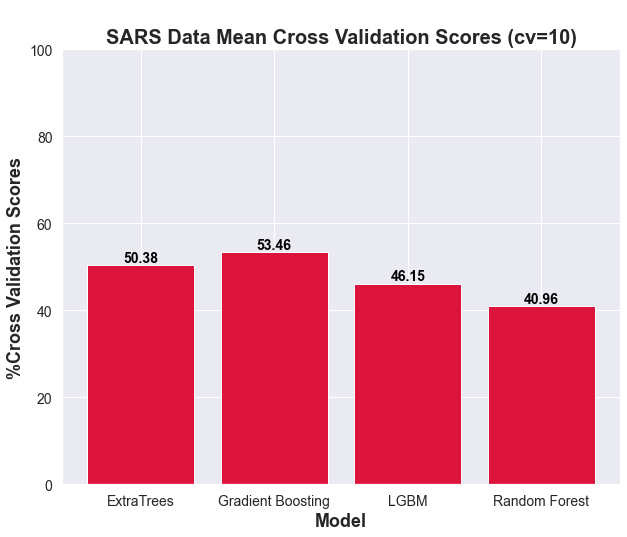

In [114]:
plt.figure(figsize=(10,8))

x_sars_models=sars_list_models
y_sars_scores=sars_list_scores

#labeling each bar with their cv score value. 
for i in range(len(y_sars_scores)):
    plt.annotate(str(y_sars_scores[i]), xy=(x_sars_models[i],y_sars_scores[i]), ha='center', 
                 fontsize=14,fontweight='bold', color='black', va='bottom')

plt.bar(x_sars_models,y_sars_scores, color='crimson')

plt.title("\nSARS Data Mean Cross Validation Scores (cv=10)",
          fontsize=20,weight='heavy')


plt.xlabel('Model',fontsize=18,weight='heavy')
plt.ylabel('%Cross Validation Scores',
           fontsize=18,weight='heavy')


plt.xticks(rotation=0, horizontalalignment='center', weight='normal', fontsize=14)
plt.yticks(weight='normal', fontsize=14)


plt.ylim(top=100) #setting y-axis limit value 

plt.show()

**Models trained from B cell performed poorly predicting on new dataset. This could mean be that the B cell dataset is not similar enough to the SARS dataset, therefore, what was learned from the B cell dataset is not transferable to the SARS dataset.**

In [115]:
print(f'Sars data: Percentage of antibody valence:\n{percentage_count}')
print()

print(f'ET mean Cross Validate scores using the sars_data: {et_mean_cv_test_rounded} ')
print(f'Antibody Valence prediction count using ExtraTrees model:\n{et_pred_sars}')
print()

print(f'GradientBoostingClassifier mean Cross Validate scores using the sars_data: {gradientboosting_mean_cv_test_rounded} ')
print(f'Antibody Valence prediction count using GradientBoostingClassifier model:\n{gradientboosting_pred_sars}')
print()

print(f'LGBM mean Cross Validate scores using the sars_data: {lgbm_mean_cv_test_rounded} ')
print(f'Antibody Valence prediction count using LGBM model:\n{lgbm_pred_sars_count}')
print()

print(f'RandomForest model mean Cross Validate scores using the sars_data: {randomforestmodel_mean_cv_test_rounded} ')
print(f'Antibody Valence prediction count using randomforestmodel model:\n{randomforestmodel_pred_sars_percentage}')



Sars data: Percentage of antibody valence:
0    73.076923
1    26.923077
Name: target, dtype: float64

ET mean Cross Validate scores using the sars_data: 50.38 
Antibody Valence prediction count using ExtraTrees model:
ET_prediction
1                62.5
0                37.5
dtype: float64

GradientBoostingClassifier mean Cross Validate scores using the sars_data: 53.46 
Antibody Valence prediction count using GradientBoostingClassifier model:
gb_pred
1          57.115385
0          42.884615
dtype: float64

LGBM mean Cross Validate scores using the sars_data: 46.15 
Antibody Valence prediction count using LGBM model:
lgbm_pred
0            51.153846
1            48.846154
dtype: float64

RandomForest model mean Cross Validate scores using the sars_data: 40.96 
Antibody Valence prediction count using randomforestmodel model:
lgbm_pred
1            61.923077
0            38.076923
dtype: float64


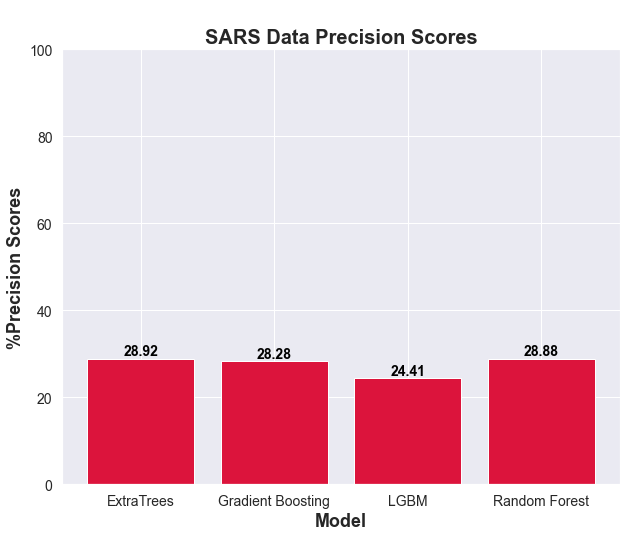

In [116]:
#Graphing Precision Scores

plt.figure(figsize=(10,8))

x_sars_models=sars_list_models
y_sars_scores=sars_preds

#labeling each bar with their cv score value. 
for i in range(len(y_sars_scores)):
    plt.annotate(str(y_sars_scores[i]), xy=(x_sars_models[i],y_sars_scores[i]), ha='center', 
                 fontsize=14,fontweight='bold', color='black', va='bottom')

plt.bar(x_sars_models,y_sars_scores, color='crimson')

plt.title("\nSARS Data Precision Scores",
          fontsize=20,weight='heavy')


plt.xlabel('Model',fontsize=18,weight='heavy')
plt.ylabel('%Precision Scores',
           fontsize=18,weight='heavy')


plt.xticks(rotation=0, horizontalalignment='center', weight='normal', fontsize=14)
plt.yticks(weight='normal', fontsize=14)


plt.ylim(top=100) #setting y-axis limit value 

plt.show()

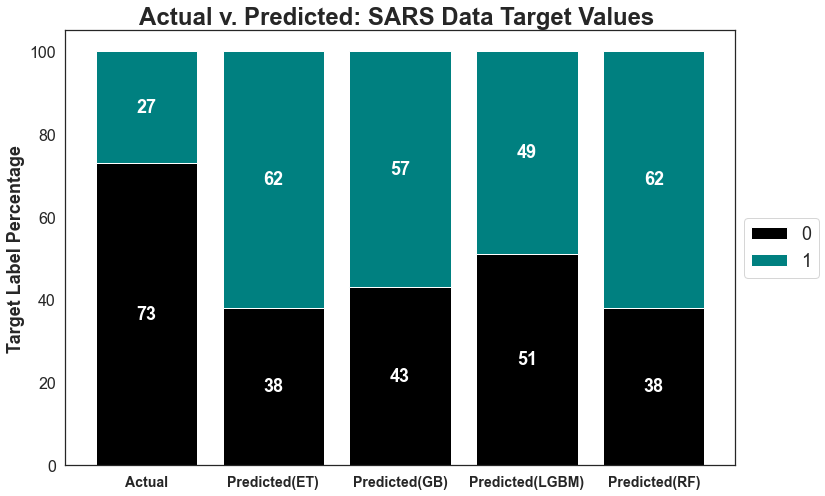

In [117]:
# stacked bar plot
sns.set_style("white")

#Get values from the group and categories
var_labels = ["Actual", "Predicted(ET)", "Predicted(GB)", "Predicted(LGBM)", "Predicted(RF)"]
neg_av= [73, 38, 43, 51, 38]
pos_av = [27,62, 57, 49,62]

    
#add colors
colors = ['black', 'teal']
# The position of the bars on the x-axis
r = range(len(var_labels))
barWidth = 0.8
#plot bars
plt.figure(figsize=(12,8))
ax1 = plt.bar(r, neg_av, color=colors[0], edgecolor='white', width=barWidth, label="0") #Negative Antibody Valency
ax2 = plt.bar(r, pos_av, bottom=np.array(neg_av), color=colors[1], edgecolor='white', width=barWidth, label='1') #Positive Antibody Valency
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(r, var_labels, fontweight='bold', fontsize=14)
plt.ylabel("Target Label Percentage", fontweight='bold', fontsize=18)
plt.title("Actual v. Predicted: SARS Data Target Values ", fontweight='bold', fontsize=24)
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
plt.savefig("stacked2.png")
plt.show()


## Predicting for Covid data target: 

Best model is the GB model with a mean cv score of 53.46%, followed by ET model 50.38%

In [118]:
covid_data=covid_data.drop(columns=["parent_protein_id", "protein_seq",
                                "peptide_seq"])

In [119]:
#checking for null values 
covid_data.isnull().sum()

start_position         0
end_position           0
chou_fasman            0
emini                  0
kolaskar_tongaonkar    0
parker                 0
isoelectric_point      0
aromaticity            0
hydrophobicity         0
stability              0
dtype: int64

In [120]:
#using best_parameters on gb model to predict on new data

#making predictions on new data  "covid_data"
gb_pred_covid=gradientboosting_model.predict(covid_data)

#setting prediction results to a df
gb_pred_covid=pd.DataFrame(gb_pred_covid,columns=['test_pred'])

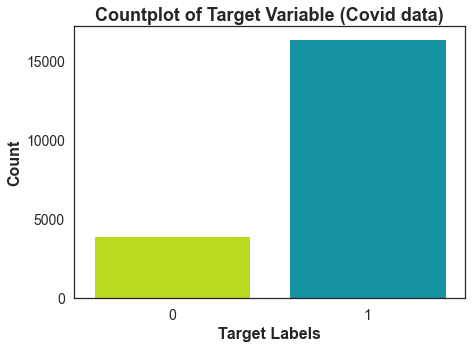

Antibody Valence prediction count:
test_pred
1            16357
0             3955
dtype: int64

Antibody Valence prediction percentage:
test_pred
1            80.528751
0            19.471249
dtype: float64


In [123]:
#counting target variable values for covid data 
plt.figure(figsize=(7,5))
sns.set_style("white")

sns.countplot(data=gb_pred_covid, x='test_pred', palette='nipy_spectral_r')
plt.title("Countplot of Target Variable (Covid data)", fontsize=18, weight='heavy')
plt.ylabel("Count", fontsize=16, weight='heavy')
plt.xlabel("Target Labels", fontsize=16, weight='heavy')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

#getting count of antibody valence count
gb_pred_count_covid=gb_pred_covid.value_counts()
gb_pred_percentage_covid=gb_pred_covid.value_counts()/len(covid_data)*100
print(f"Antibody Valence prediction count:\n{gb_pred_count_covid}")
print()
print(f'Antibody Valence prediction percentage:\n{gb_pred_percentage_covid}')

In [124]:
#using et model to predict on new data


#making predictions on new data  "covid_data"
et_pred_covid=extratreesmodel.predict(covid_data)

#setting prediction results to a df
et_pred_covid=pd.DataFrame(et_pred_covid,columns=['test_pred'])

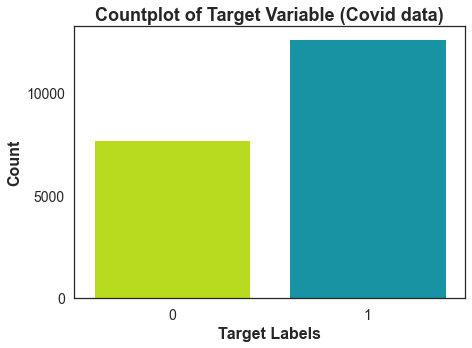

Antibody Valence prediction count:
test_pred
1            12619
0             7693
dtype: int64

Antibody Valence prediction percentage:
test_pred
1            62.125837
0            37.874163
dtype: float64


In [126]:
#counting target variable values for covid data 
plt.figure(figsize=(7,5))
sns.set_style("white")

sns.countplot(data=et_pred_covid, x='test_pred', palette='nipy_spectral_r')
plt.title("Countplot of Target Variable (Covid data)", fontsize=18, weight='heavy')
plt.ylabel("Count", fontsize=16, weight='heavy')
plt.xlabel("Target Labels", fontsize=16, weight='heavy')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

#getting count of antibody valence count
et_pred_count_covid=et_pred_covid.value_counts()
et_pred_percentage_covid=et_pred_covid.value_counts()/len(covid_data)*100
print(f"Antibody Valence prediction count:\n{et_pred_count_covid}")
print()
print(f'Antibody Valence prediction percentage:\n{et_pred_percentage_covid}')

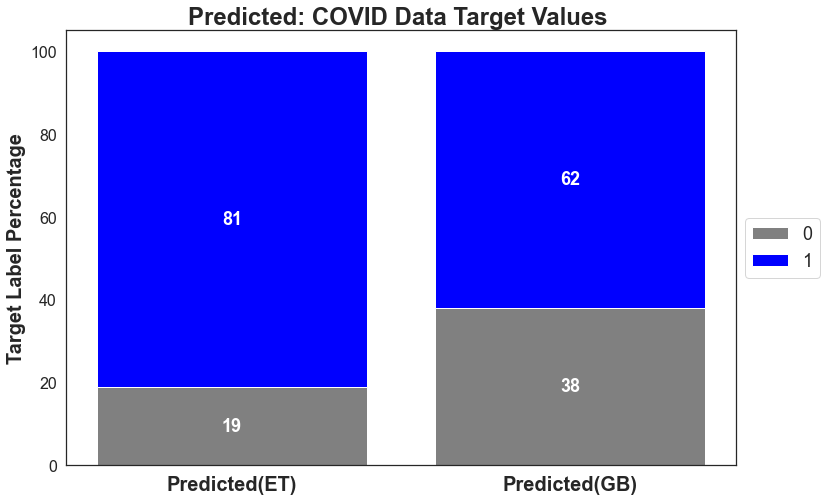

In [127]:
# stacked bar plot
sns.set_style("white")

#Get values from the group and categories
var_labels = ["Predicted(ET)", "Predicted(GB)"]
neg_av= [19, 38]
pos_av = [81,62]

    
#add colors
colors = ['grey', 'blue']
# The position of the bars on the x-axis
r = range(len(var_labels))
barWidth = 0.8
#plot bars
plt.figure(figsize=(12,8))
ax1 = plt.bar(r, neg_av, color=colors[0], edgecolor='white', width=barWidth, label="0") #Negative Antibody Valency
ax2 = plt.bar(r, pos_av, bottom=np.array(neg_av), color=colors[1], edgecolor='white', width=barWidth, label='1') #Positive Antibody Valency
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(r, var_labels, fontweight='bold', fontsize=20)
plt.ylabel("Target Label Percentage", fontweight='bold', fontsize=20)
plt.title("Predicted: COVID Data Target Values ", fontweight='bold', fontsize=24)
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=18, fontweight="bold")
plt.savefig("stacked2.png")
plt.show()



**With a little over a 50% using the mean 10-fold cross validation score, the GB Model predicts that within the COVID dataset, there are 81% Positive antibody valence and 19% negative antibody valence. Also with 50% accuracy, the ET model predicts 62% Positive Antibody Valence and 38% Negative Antibody Valence. These results indicate that there are more positive antibody valence than negative antibody valence.**

#### Future Directions:
1. Optimize models by applying more parameter combinations 
2. Feature engineering 